### Imports

In [3]:
from tqdm import tqdm
import random
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_mtsim
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/")
from gym_mtsim_forked.gym_mtsim.data import FOREX_DATA_PATH_TRAIN, FOREX_DATA_PATH_TEST, FOREX_DATA_PATH
from gym_mtsim import OrderType, Timeframe, MtEnv, MtSimulator
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, STATUS_FAIL
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
import time
import torch
import pickle
import fx_rl
from datetime import datetime, timedelta

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-unhedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-unhedge-v0 alr

## Latest Data

In [4]:
with open(FOREX_DATA_PATH, 'rb') as f:
    symbols_1hr = pickle.load(f)
# convert symbols_1hr to a pd.dataframe
symbols_1hr[1]['EURUSD'].index = pd.to_datetime(symbols_1hr[1]['EURUSD'].index)
max_date_1hr = symbols_1hr[1]['EURUSD'].index.max()

In [5]:
slices_1hr = fx_rl.slices_finder(symbols_1hr[1]['EURUSD'], max_date_1hr, testing_needed=False)

### Create Env

In [6]:
sim_train = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

In [7]:
class MyMtEnv(MtEnv):
    _get_modified_volume = fx_rl.my_get_modified_volume

In [8]:
env_train = gym_mtsim.MtEnv(
    original_simulator=sim_train,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=slices_1hr[0],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [9]:
sim_validation = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_validation = gym_mtsim.MtEnv(
    original_simulator=sim_validation,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=slices_1hr[1],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [11]:
# sim_testing = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH
# )

# env_testing = gym_mtsim.MtEnv(
#     original_simulator=sim_testing,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_1hr[2],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

### Define Functions

In [12]:
def print_stats(reward_over_episodes, printing_name):
    """  Print Reward  """

    avg_rewards = np.mean(reward_over_episodes)
    min_rewards = np.min(reward_over_episodes)
    max_rewards = np.max(reward_over_episodes)

    print (f'Min. {printing_name}          : {min_rewards:>10.3f}')
    print (f'Avg. {printing_name}          : {avg_rewards:>10.3f}')
    print (f'Max. {printing_name}          : {max_rewards:>10.3f}')

    return min_rewards, avg_rewards, max_rewards

def my_profit_calculation(env_orders, stop_loss):
        # env_orders = env_testing.render()['orders']
        # stop_loss = 0.001

        mean_value = env_orders['Volume'].mean()

        # Normalize the column to have a mean of 1
        env_orders.loc[:, 'Volume'] = round((env_orders['Volume'] / mean_value), 2)

        # add a column for when the difference between the Entry Price and the Exit Price is greater than stop_loss
        env_orders.loc[:, 'stoploss_hit'] = np.where((env_orders['Type'].str.strip() == 'Buy') &
                                                        ((env_orders['Entry Price'] - env_orders['Exit Price']) > stop_loss),
                                                        1, np.where((env_orders['Type'].str.strip() == 'Sell') &
                                                                        ((env_orders['Exit Price'] - env_orders['Entry Price']) > stop_loss),
                                                                        1, 0))
        env_orders.loc[:, 'Exit Price'] = np.where((env_orders['Type'].str.strip() == 'Buy') & (env_orders['stoploss_hit'] == 1),
                                                        env_orders['Entry Price'] - stop_loss,
                                                        np.where((env_orders['Type'].str.strip() == 'Sell') & (env_orders['stoploss_hit'] == 1),
                                                                env_orders['Entry Price'] + stop_loss, env_orders['Exit Price']))
        env_orders.loc[:, 'Profit'] = np.where((env_orders['Type'].str.strip() == 'Buy'),
                                                        ((env_orders['Exit Price'] - (env_orders['Fee']/2)) - 
                                                        (env_orders['Entry Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume'], 
                                                        np.where((env_orders['Type'].str.strip() == 'Sell'),
                                                                ((env_orders['Entry Price'] - (env_orders['Fee']/2)) - 
                                                                (env_orders['Exit Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume'], np.nan))
        total_reward = env_orders.loc[:, 'Profit'].sum()
        # Calculate Gross Profit
        gross_profit = env_orders.loc[env_orders['Profit'] > 0, 'Profit'].sum()

        # Calculate Gross Loss
        gross_loss = env_orders.loc[env_orders['Profit'] < 0, 'Profit'].abs().sum()

        # Calculate Profit Factor
        profit_factor = gross_profit / gross_loss if gross_loss != 0 else 0

        profit_factor = profit_factor - 1

        return profit_factor, total_reward

# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


In [ ]:
space = {
    # 'learning_rate': hp.loguniform('learning_rate', -5, -2), # Learning rate
    'learning_rate': hp.uniform('learning_rate', 0, 0.04), # Learning rate
    'gamma': hp.uniform('gamma', 0.925, 0.975), # Discount factor
    # 'ent_coef': hp.loguniform('ent_coef', -5, 0) # Entropy coefficient
    'ent_coef': hp.uniform('ent_coef', 0, 0.05) # Entropy coefficient
    # 'learning_timesteps': hp.choice('learning_timesteps', [25, 50, 100, 250, 500]),
}

In [13]:
# TRAINING + TEST
def train_val_model(model, model_policy, env_tr, env_val, seed, steps_str, lr, gamma_param, entropy, total_learning_timesteps=10_000):
    """
    Trains and validates a model using the Proximal Policy Optimization (PPO) algorithm.

    Args:
        model (object): The model to be trained.
        model_policy (object): The policy used by the model.
        env_tr (object): The training environment.
        env_val (object): The validation environment.
        seed (int): The random seed for reproducibility.
        steps_str (str): A string representing the number of steps.
        window_size_param (int): The window size parameter.
        lr (float): The learning rate.
        gamma_param (float): The gamma parameter.
        entropy (float): The entropy coefficient.
        total_learning_timesteps (int, optional): The total number of learning timesteps. Defaults to 10,000.

    Returns:
        tuple: A tuple containing the reward over validations, orders over validations, and the model dictionary.
    """
    # reproduce training and test
    print('-' * 80)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    #model_dict = {}
    # env_tr.window_size = window_size_param
    print(f'entropy: {entropy}, learning rate: {lr}, gamma: {gamma_param}')
    # eval_callback = EvalCallback(env_tr, log_path='./logs/', eval_freq=1000)
    obs_tr, info_tr = env_tr.reset(seed=seed)
    model = PPO(model_policy, env_tr, verbose=0, ent_coef=entropy, learning_rate=lr, gamma=gamma_param)
    
    # custom callback for 'progress_bar'
    model.learn(total_timesteps=total_learning_timesteps)#, callback=ProgressBarCallback(100))

    reward_over_validations = []
    orders_over_validations = []
    profit_over_validations = []

    for episode in range(0, 10):
        obs_val, info_val = env_val.reset(seed=seed)

        total_reward = 0
        done_val = False

        while not done_val:
            action, _states = model.predict(obs_val)
            obs_val, reward_val, terminated_val, truncated_val, info_val = env_val.step(action)
            done_val = terminated_val or truncated_val

            total_reward += reward_val
            if done_val:
                break
        try:
            orders_made_in_episode = env_val.render()['orders']
            order_len = len(orders_made_in_episode)
            total_reward, total_profit = my_profit_calculation(orders_made_in_episode, 0.001)
            
        except Exception as e:
            print(f'There were not any orders produced by the model. Error = {e}')
            order_len = 0
            total_profit = 0

        # model_dict[f'model_{episode}'] = model
        # model.save(f'best_hyperparameters/models_4_26_24/model_{episode}.pkl')

        reward_over_validations.append(total_reward) 
        profit_over_validations.append(total_profit)   
        orders_over_validations.append(order_len)  


        # if episode % 1 == 0:
        avg_reward = np.mean(reward_over_validations)
        avg_orders = np.mean(orders_over_validations)
        avg_profit = np.mean(profit_over_validations)
        print(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}, # of orders: {avg_orders:.3f}, avg Profit: {avg_profit:.3f}')

    return reward_over_validations, orders_over_validations, profit_over_validations#, model_dict

## Objective Function

In [14]:
seed = 2024  # random seed
total_num_episodes = 10

# print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# learning_timesteps_list_in_K = [25]#, 50, 100]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html

timesteps_models_dict = {}
def objective(params):
    learning_timesteps = 100 #params['learning_timesteps']
    ent_coef = params['ent_coef']
    gamma = params['gamma'] #0.99 #
    learning_rate = params['learning_rate']#0.0003#

    if learning_rate > 0.08:
        print(f'Learning rate too high: {learning_rate}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    if ent_coef > 0.1:
        print(f'Entropy too high: {ent_coef}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}

    total_learning_timesteps = learning_timesteps * 1000
    step_key = f'{learning_timesteps}K'
    policy_dict = PPO.policy_aliases
    policy = policy_dict.get('MultiInputPolicy')
    class_name = type(PPO).__qualname__
    plot_key = f'{class_name}_rewards_'+step_key
    try:
        rewards, orders, profits = train_val_model(PPO, policy, env_train, env_validation, seed, step_key,  
                                                    learning_rate, gamma, ent_coef, total_learning_timesteps)
    except Exception as e:
        print(f'''there was an error {e} with those parameters: timesteps: {learning_timesteps}, \n
              ent_coef: {ent_coef}, gamma: {gamma}, learning_rate: {learning_rate}''')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    # timesteps_models_dict[step_key] = models_dict
    min_rewards, avg_rewards, max_rewards, = print_stats(rewards, 'Reward')
    print_stats(orders, 'Orders')
    label = f'Avg. {avg_rewards:>7.2f} : {class_name} - {step_key}'
    plot_data[plot_key] = rewards
    plot_settings[plot_key] = {'label': label}
    params['avg_orders'] = np.mean(orders)
    params['profits'] = np.mean(profits)       

    return {'loss': -avg_rewards, 'status': STATUS_OK, 'eval_time': time.time(), 'parameters': params} 

seed                     : 2024


In [ ]:
# make a sound when the code is done
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 2000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

# Testing Hyperparameters

In [ ]:
# trials_new_volume = pickle.load(open(f'gym_mtsim_forked/examples/hyperopt/trials_5_4_new_volume_calc.pkl', 'rb'))
# for trial in trials_new_volume.results:
#     trial['volume'] = 'new'
# trials_new_volume_all_results = trials_new_volume.results
# print(len(trials_new_volume_all_results),
# trials_new_volume_all_results[0])

250 {'loss': 0.06570791805836697, 'status': 'ok', 'eval_time': 1714831232.8801224, 'parameters': {'ent_coef': 0.04143205673569363, 'gamma': 0.9424504160558614, 'learning_rate': 0.03297427713019841, 'avg_orders': 52.0, 'profits': -364.51408897294687}, 'volume': 'new'}


In [ ]:
# trials_old_volume = pickle.load(open(f'gym_mtsim_forked/examples/hyperopt/trials_5_4_old_volume_calc.pkl', 'rb'))
# for trial in trials_old_volume.results:
#     trial['volume'] = 'old'
# trials_old_volume_all_results = trials_old_volume.results
# print(len(trials_old_volume_all_results),
# trials_old_volume_all_results[0])

250 {'loss': 0.05516586710846163, 'status': 'ok', 'eval_time': 1714900584.177036, 'parameters': {'ent_coef': 0.03671520879085809, 'gamma': 0.944258134765221, 'learning_rate': 0.00889422384227362, 'avg_orders': 47.0, 'profits': -8908.584498398583}, 'volume': 'old'}


In [ ]:
# trials_latest_week = pickle.load(open(f'gym_mtsim_forked/examples/hyperopt/trials_5_5_latest_week.pkl', 'rb'))
# trials_latest_week_all_results = trials_latest_week.results
# print(len(trials_latest_week_all_results),
# trials_latest_week_all_results[0])

In [17]:
trials_timeframe = pickle.load(open(f'gym_mtsim_forked/examples/hyperopt/trials_5_16_timeframe_analysis_daily_retraining.pkl', 'rb'))
# for trial in trials_next_week_new_reward.results:
#     trial['reward'] = 'new'
trials_timeframe_all_results = trials_timeframe.results
print(len(trials_timeframe_all_results),
trials_timeframe_all_results[2])


200 {'loss': -43.92846965313524, 'status': 'ok', 'eval_time': 1715879443.1124227, 'parameters': {'ent_coef': 0.007380827751214092, 'gamma': 0.9689885727306781, 'learning_rate': 0.06662869463305662, 'timeframe': '1hr', 'avg_orders': 5.24, 'profits': 1.171841276467597}}


In [14]:
# trials_next_week_old_reward = pickle.load(open(f'gym_mtsim_forked/examples/hyperopt/trials_5_13_search_next_week.pkl', 'rb'))
# for trial in trials_next_week_old_reward.results:
#     trial['reward'] = 'old'
# trials_next_week_old_reward_all_results = trials_next_week_old_reward.results
# print(len(trials_next_week_old_reward_all_results),
# trials_next_week_old_reward_all_results[0])

250 {'loss': 173.01180931909693, 'status': 'ok', 'eval_time': 1715592258.8334138, 'parameters': {'ent_coef': 0.038233205176373915, 'gamma': 0.9261280805355149, 'learning_rate': 0.03529849961969178, 'avg_orders': 36.7, 'rewards': -173.01180931909693}, 'reward': 'old'}


In [10]:
# trials_all_results = trials_next_week_new_reward_all_results + trials_next_week_old_reward_all_results

In [18]:
results_df = pd.DataFrame()
new_dict = {}
for idx, result in enumerate(trials_timeframe_all_results):
    new_dict['loss'] = result['loss']
    new_dict['status'] = result['status']
    new_dict['learning_rate'] = result['parameters']['learning_rate']
    new_dict['ent_coef'] = result['parameters']['ent_coef']
    new_dict['gamma'] = result['parameters']['gamma']
    new_dict['timeframe'] = result['parameters']['timeframe']
    try:
        new_dict['orders'] = result['parameters']['avg_orders']
        new_dict['profit_factor'] = result['parameters']['profits']
    except: 
        new_dict['orders'] = 0
        new_dict['profit_factor'] = 0
    new_row = pd.DataFrame(new_dict, index=[idx])
    results_df = pd.concat([results_df, new_row], axis=0)
results_df


,loss,status,learning_rate,ent_coef,gamma,timeframe,orders,profit_factor
0,NaN,fail,0.078195,0.046766,0.951821,1hr,0.00,0.000000
1,-22.482224,ok,0.009828,0.015900,0.949115,1hr,5.96,23.520459
2,-43.92847,ok,0.066629,0.007381,0.968989,1hr,5.24,1.171841
3,None,fail,0.041559,0.139451,0.973851,1hr,0.00,0.000000
4,None,fail,0.057560,0.072832,0.969219,15min,0.00,0.000000
...,...,...,...,...,...,...,...,...
195,None,fail,0.049841,0.048067,0.940462,15min,0.00,0.000000
196,840.301274,ok,0.044921,0.010962,0.927550,5min,90.32,-0.593752
197,-57.159589,ok,0.024584,0.030840,0.930219,1hr,5.18,2.279942
198,-50.503253,ok,0.007014,0.025656,0.967585,1hr,6.66,4.353811


In [19]:
results_df.loc[:, 'loss_binary'] = np.where(results_df['loss'] < 0, 1, 0)
# results_df_low_entropy = results_df[results_df['ent_coef'] < 0.1]

In [20]:
# custom_palette = sns.color_palette(["red", "green"])
custom_palette = {'ok': 'green', 'fail': 'red', 0: 'red', 1: 'green', 'old': 'blue', 'new': 'green'}

## Success Plots

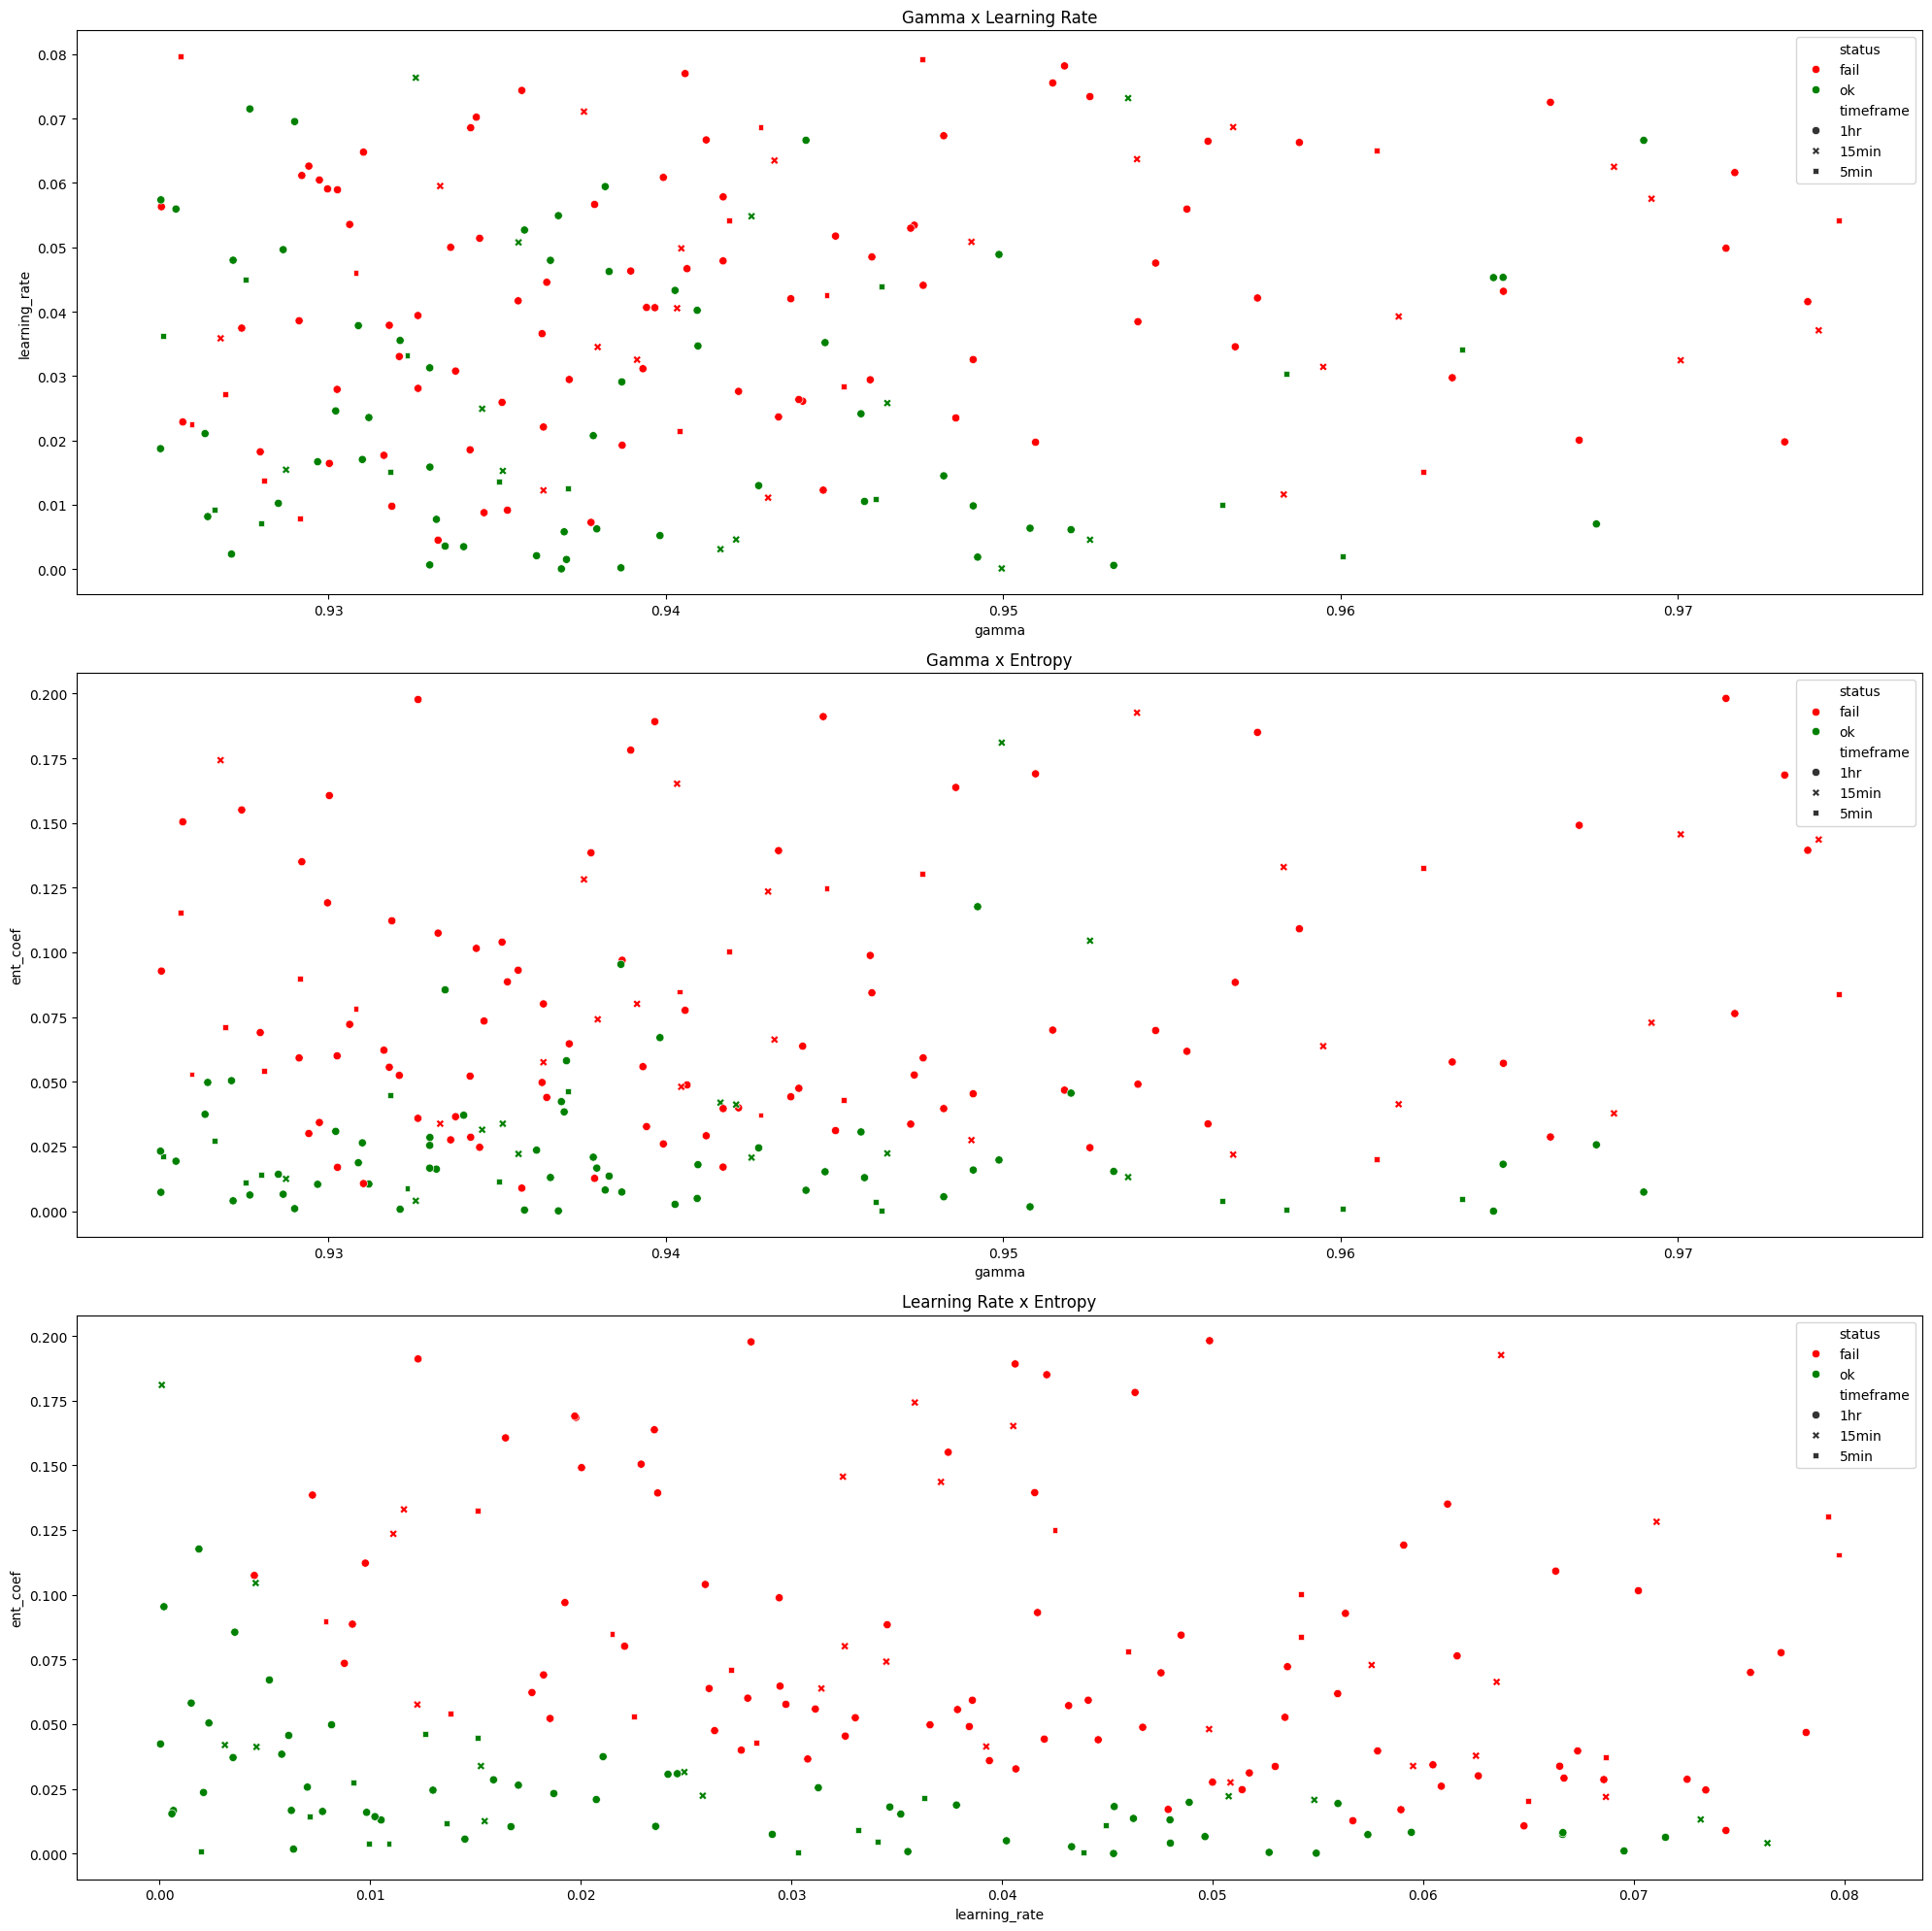

In [28]:
# create 3 figures for the combination of all 3 hyperparameters, learning rate, entropy, and gamma, and I want them stacked with one figure per row and 3 rows to compare the failure distribution of each hyperparameter combination 
# gamma x learning rate, gamma x entropy, learning rate x entropy
# first create the subplot that each figure will go into with 1 column and 3 rows
fig, axs = plt.subplots(3, 1, figsize=(20, 20))
# create the first subplot with gamma x learning rate and status of ok being green and fail being red change the shape of the dots based on 'timeframe' col
sns.scatterplot(data=results_df, x='gamma', y='learning_rate', hue='status', ax=axs[0], palette=custom_palette, style='timeframe')
axs[0].set_title('Gamma x Learning Rate')
# create the second subplot with gamma x entropy and status of ok being green and fail being red
sns.scatterplot(data=results_df, x='gamma', y='ent_coef', hue='status', ax=axs[1], palette=custom_palette, style='timeframe')
axs[1].set_title('Gamma x Entropy')
# create the third subplot with learning rate x entropy and status of ok being green and fail being red
sns.scatterplot(data=results_df, x='learning_rate', y='ent_coef', hue='status', ax=axs[2], palette=custom_palette, style='timeframe')
axs[2].set_title('Learning Rate x Entropy')
# add some space between each figure
plt.tight_layout()
# plot the figure
plt.show()

## Loss Binary Plots

In [22]:
results_df_success = results_df[results_df['status'] == 'ok']

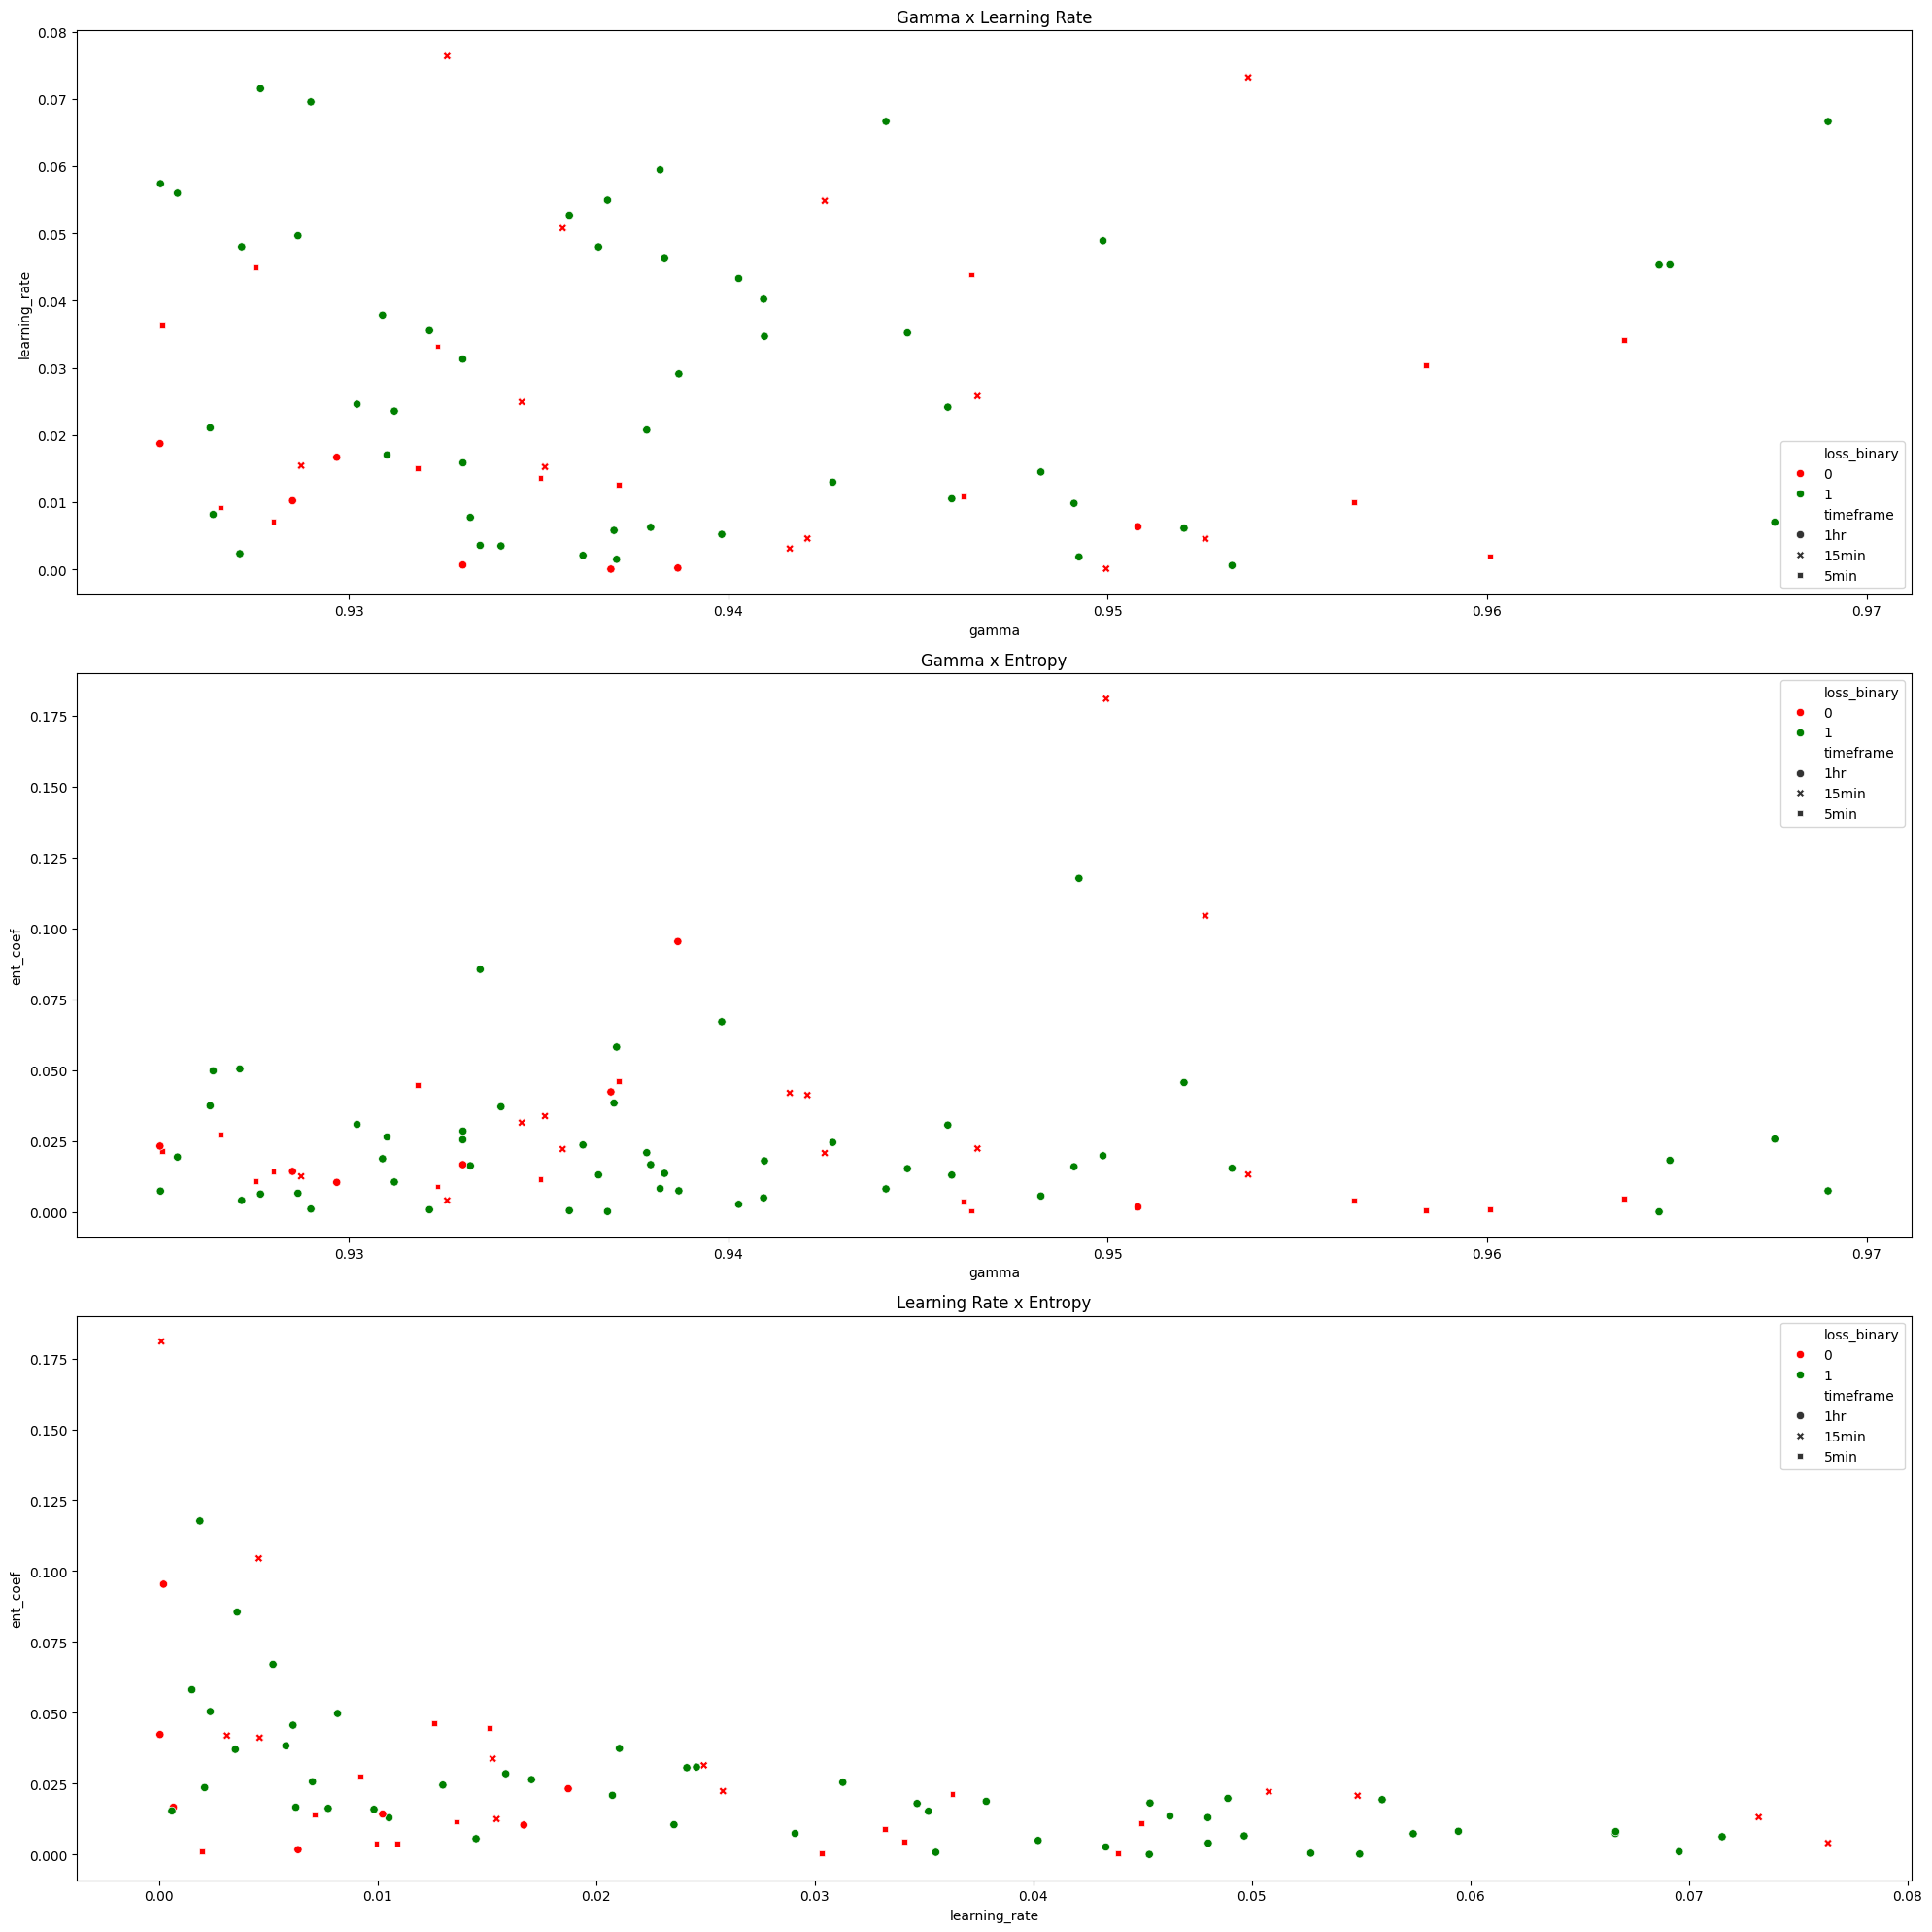

In [29]:
# create 3 figures for the combination of all 3 hyperparameters, learning rate, entropy, and gamma, and I want them stacked with one figure per row and 3 rows to compare the failure distribution of each hyperparameter combination 
# gamma x learning rate, gamma x entropy, learning rate x entropy
# first create the subplot that each figure will go into with 1 column and 3 rows
fig, axs = plt.subplots(3, 1, figsize=(20, 20))
# create the first subplot with gamma x learning rate and loss_binary of ok being green and fail being red
sns.scatterplot(data=results_df_success, x='gamma', y='learning_rate', hue='loss_binary', ax=axs[0], palette=custom_palette, style='timeframe')
axs[0].set_title('Gamma x Learning Rate')
# create the second subplot with gamma x entropy and loss_binary of ok being green and fail being red
sns.scatterplot(data=results_df_success, x='gamma', y='ent_coef', hue='loss_binary', ax=axs[1], palette=custom_palette, style='timeframe')
axs[1].set_title('Gamma x Entropy')
# create the third subplot with learning rate x entropy and loss_binary of ok being green and fail being red
sns.scatterplot(data=results_df_success, x='learning_rate', y='ent_coef', hue='loss_binary', ax=axs[2], palette=custom_palette, style='timeframe')
axs[2].set_title('Learning Rate x Entropy')
# add some space between each figure
plt.tight_layout()
# plot the figure
plt.show()

In [25]:
results_df_negative = results_df_success[results_df_success['loss'] < 0]

## Non-Binary Loss Plots

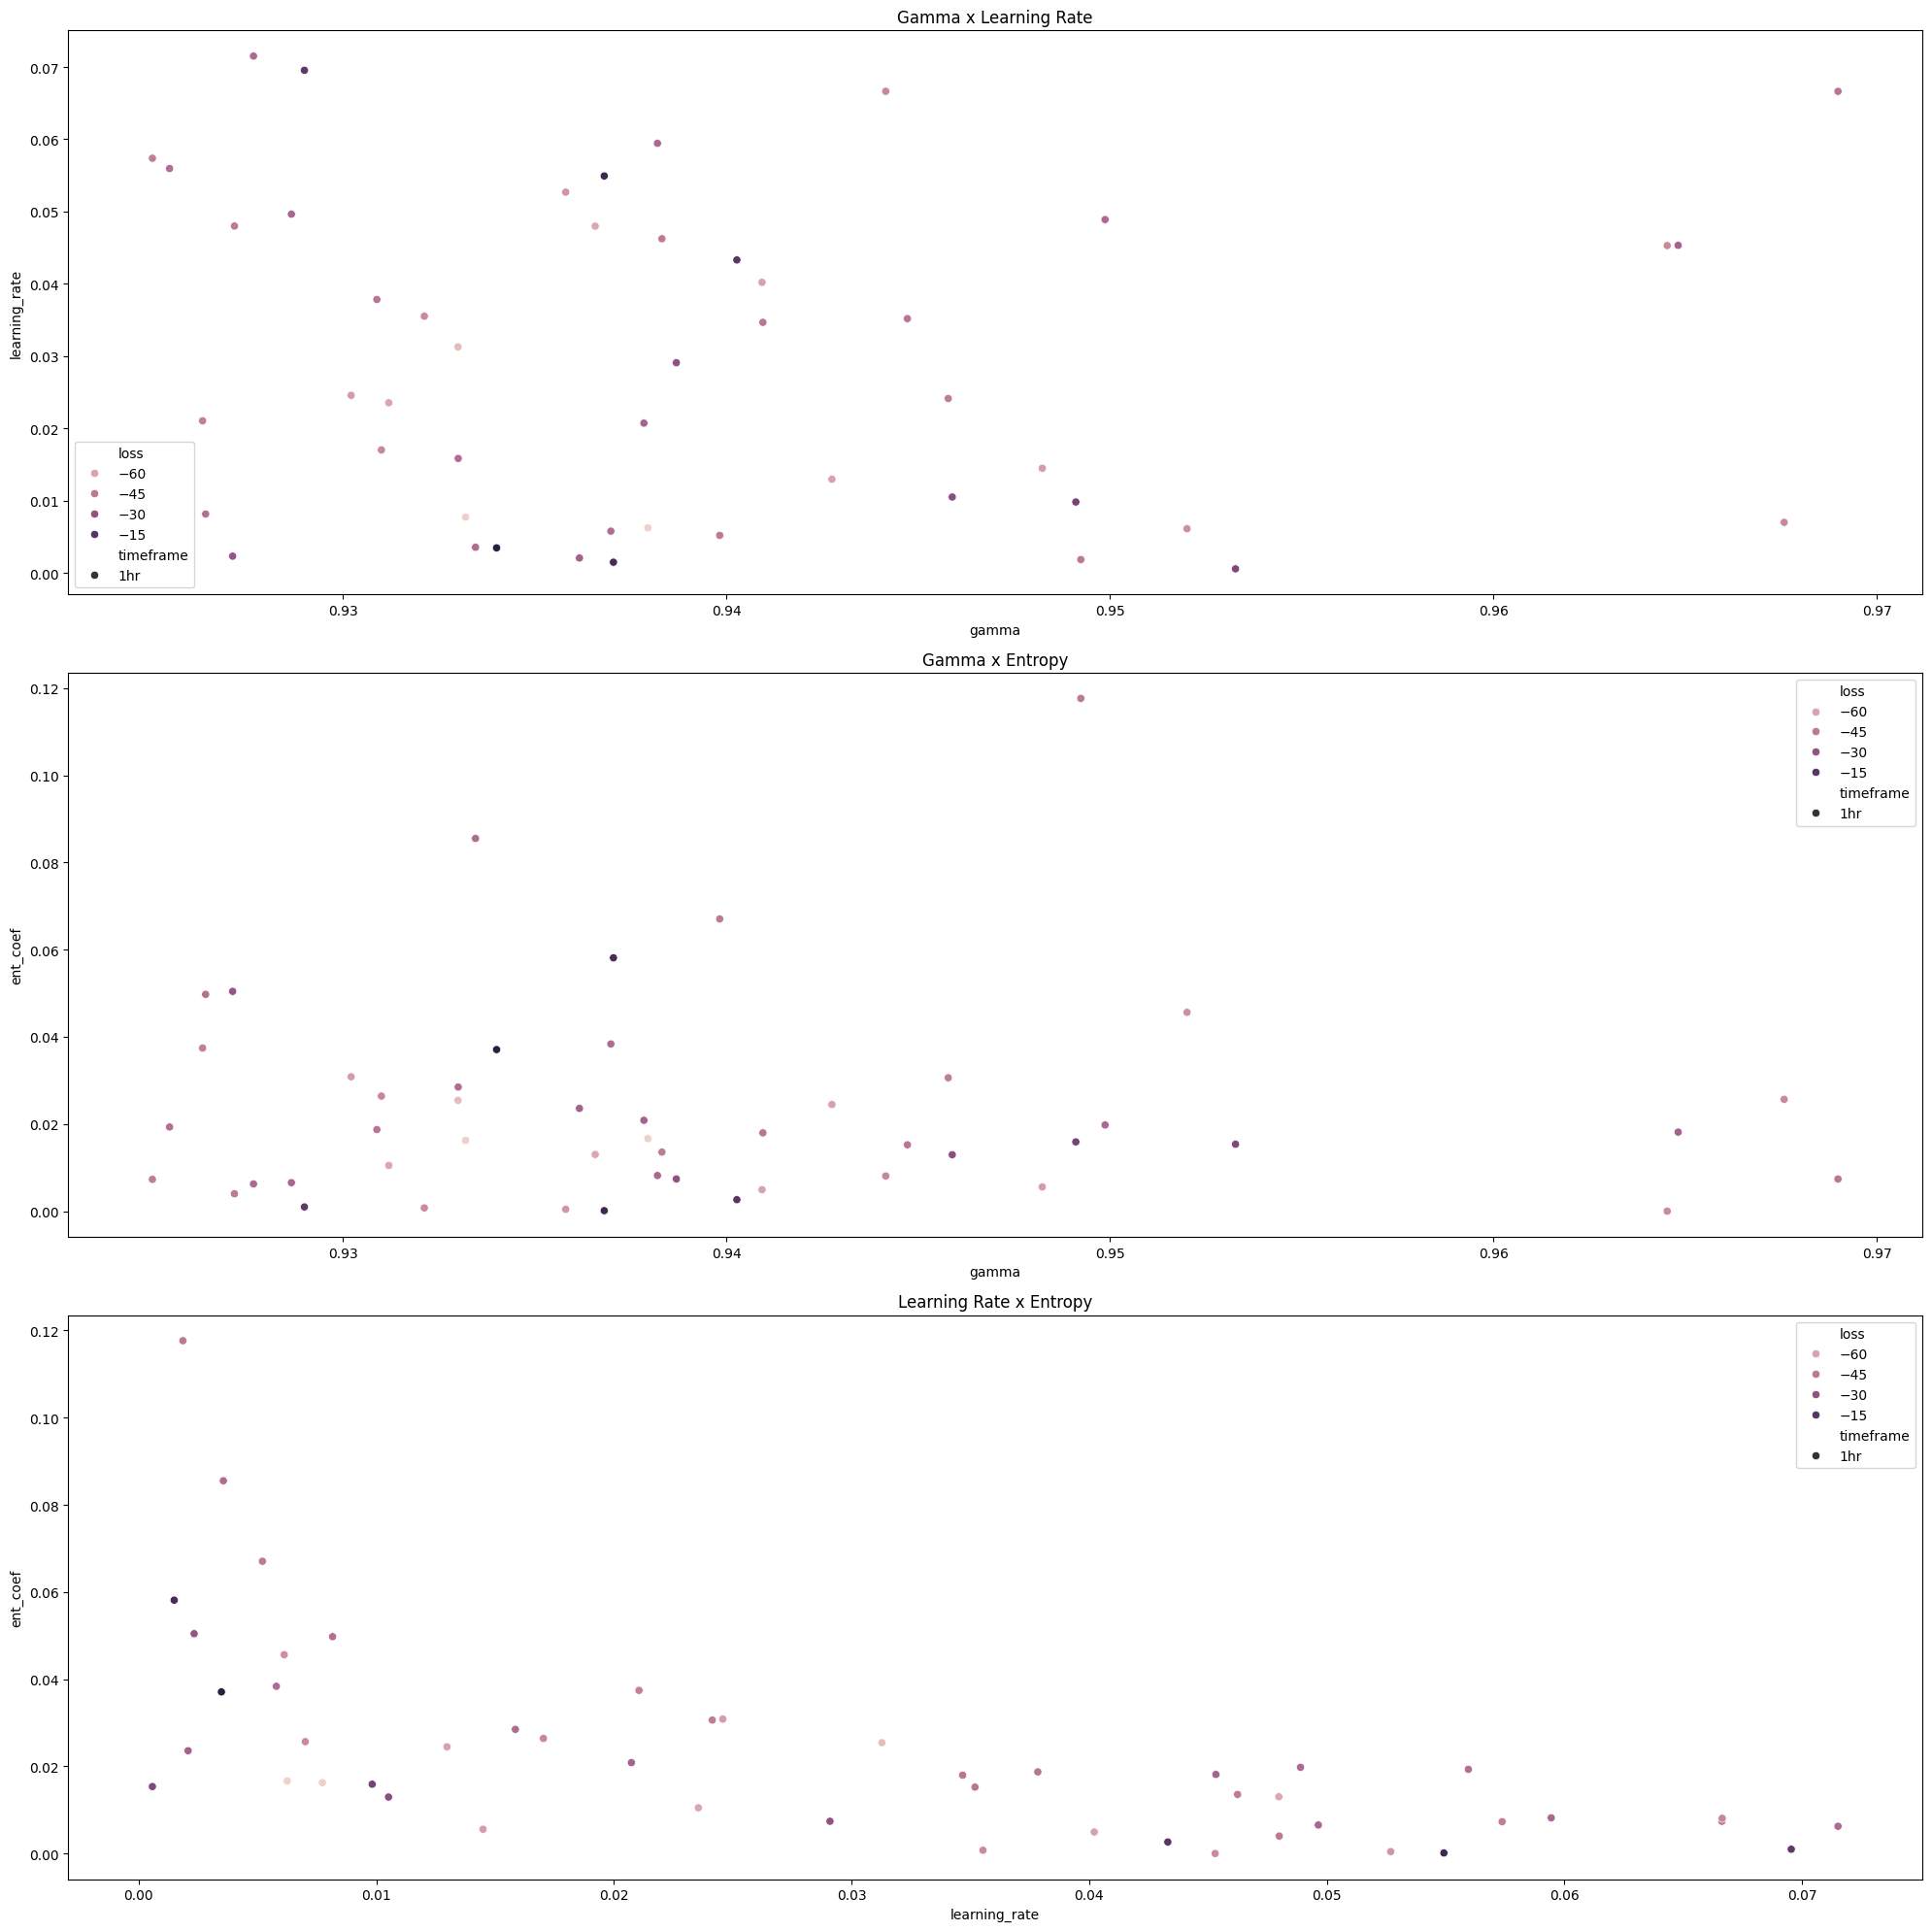

In [30]:
# create 3 figures for the combination of all 3 hyperparameters, learning rate, entropy, and gamma, and I want them stacked with one figure per row and 3 rows to compare the failure distribution of each hyperparameter combination 
# gamma x learning rate, gamma x entropy, learning rate x entropy
# first create the subplot that each figure will go into with 1 column and 3 rows
fig, axs = plt.subplots(3, 1, figsize=(20, 20))
# create the first subplot with gamma x learning rate and loss of ok being green and fail being red
sns.scatterplot(data=results_df_negative, x='gamma', y='learning_rate', hue='loss', ax=axs[0], style='timeframe')
axs[0].set_title('Gamma x Learning Rate')
# create the second subplot with gamma x entropy and loss of ok being green and fail being red
sns.scatterplot(data=results_df_negative, x='gamma', y='ent_coef', hue='loss', ax=axs[1], style='timeframe')
axs[1].set_title('Gamma x Entropy')
# create the third subplot with learning rate x entropy and loss of ok being green and fail being red
sns.scatterplot(data=results_df_negative, x='learning_rate', y='ent_coef', hue='loss', ax=axs[2], style='timeframe')
axs[2].set_title('Learning Rate x Entropy')
# add some space between each figure
plt.tight_layout()
# plot the figure
plt.show()

## Hyperparameters vs loss plots

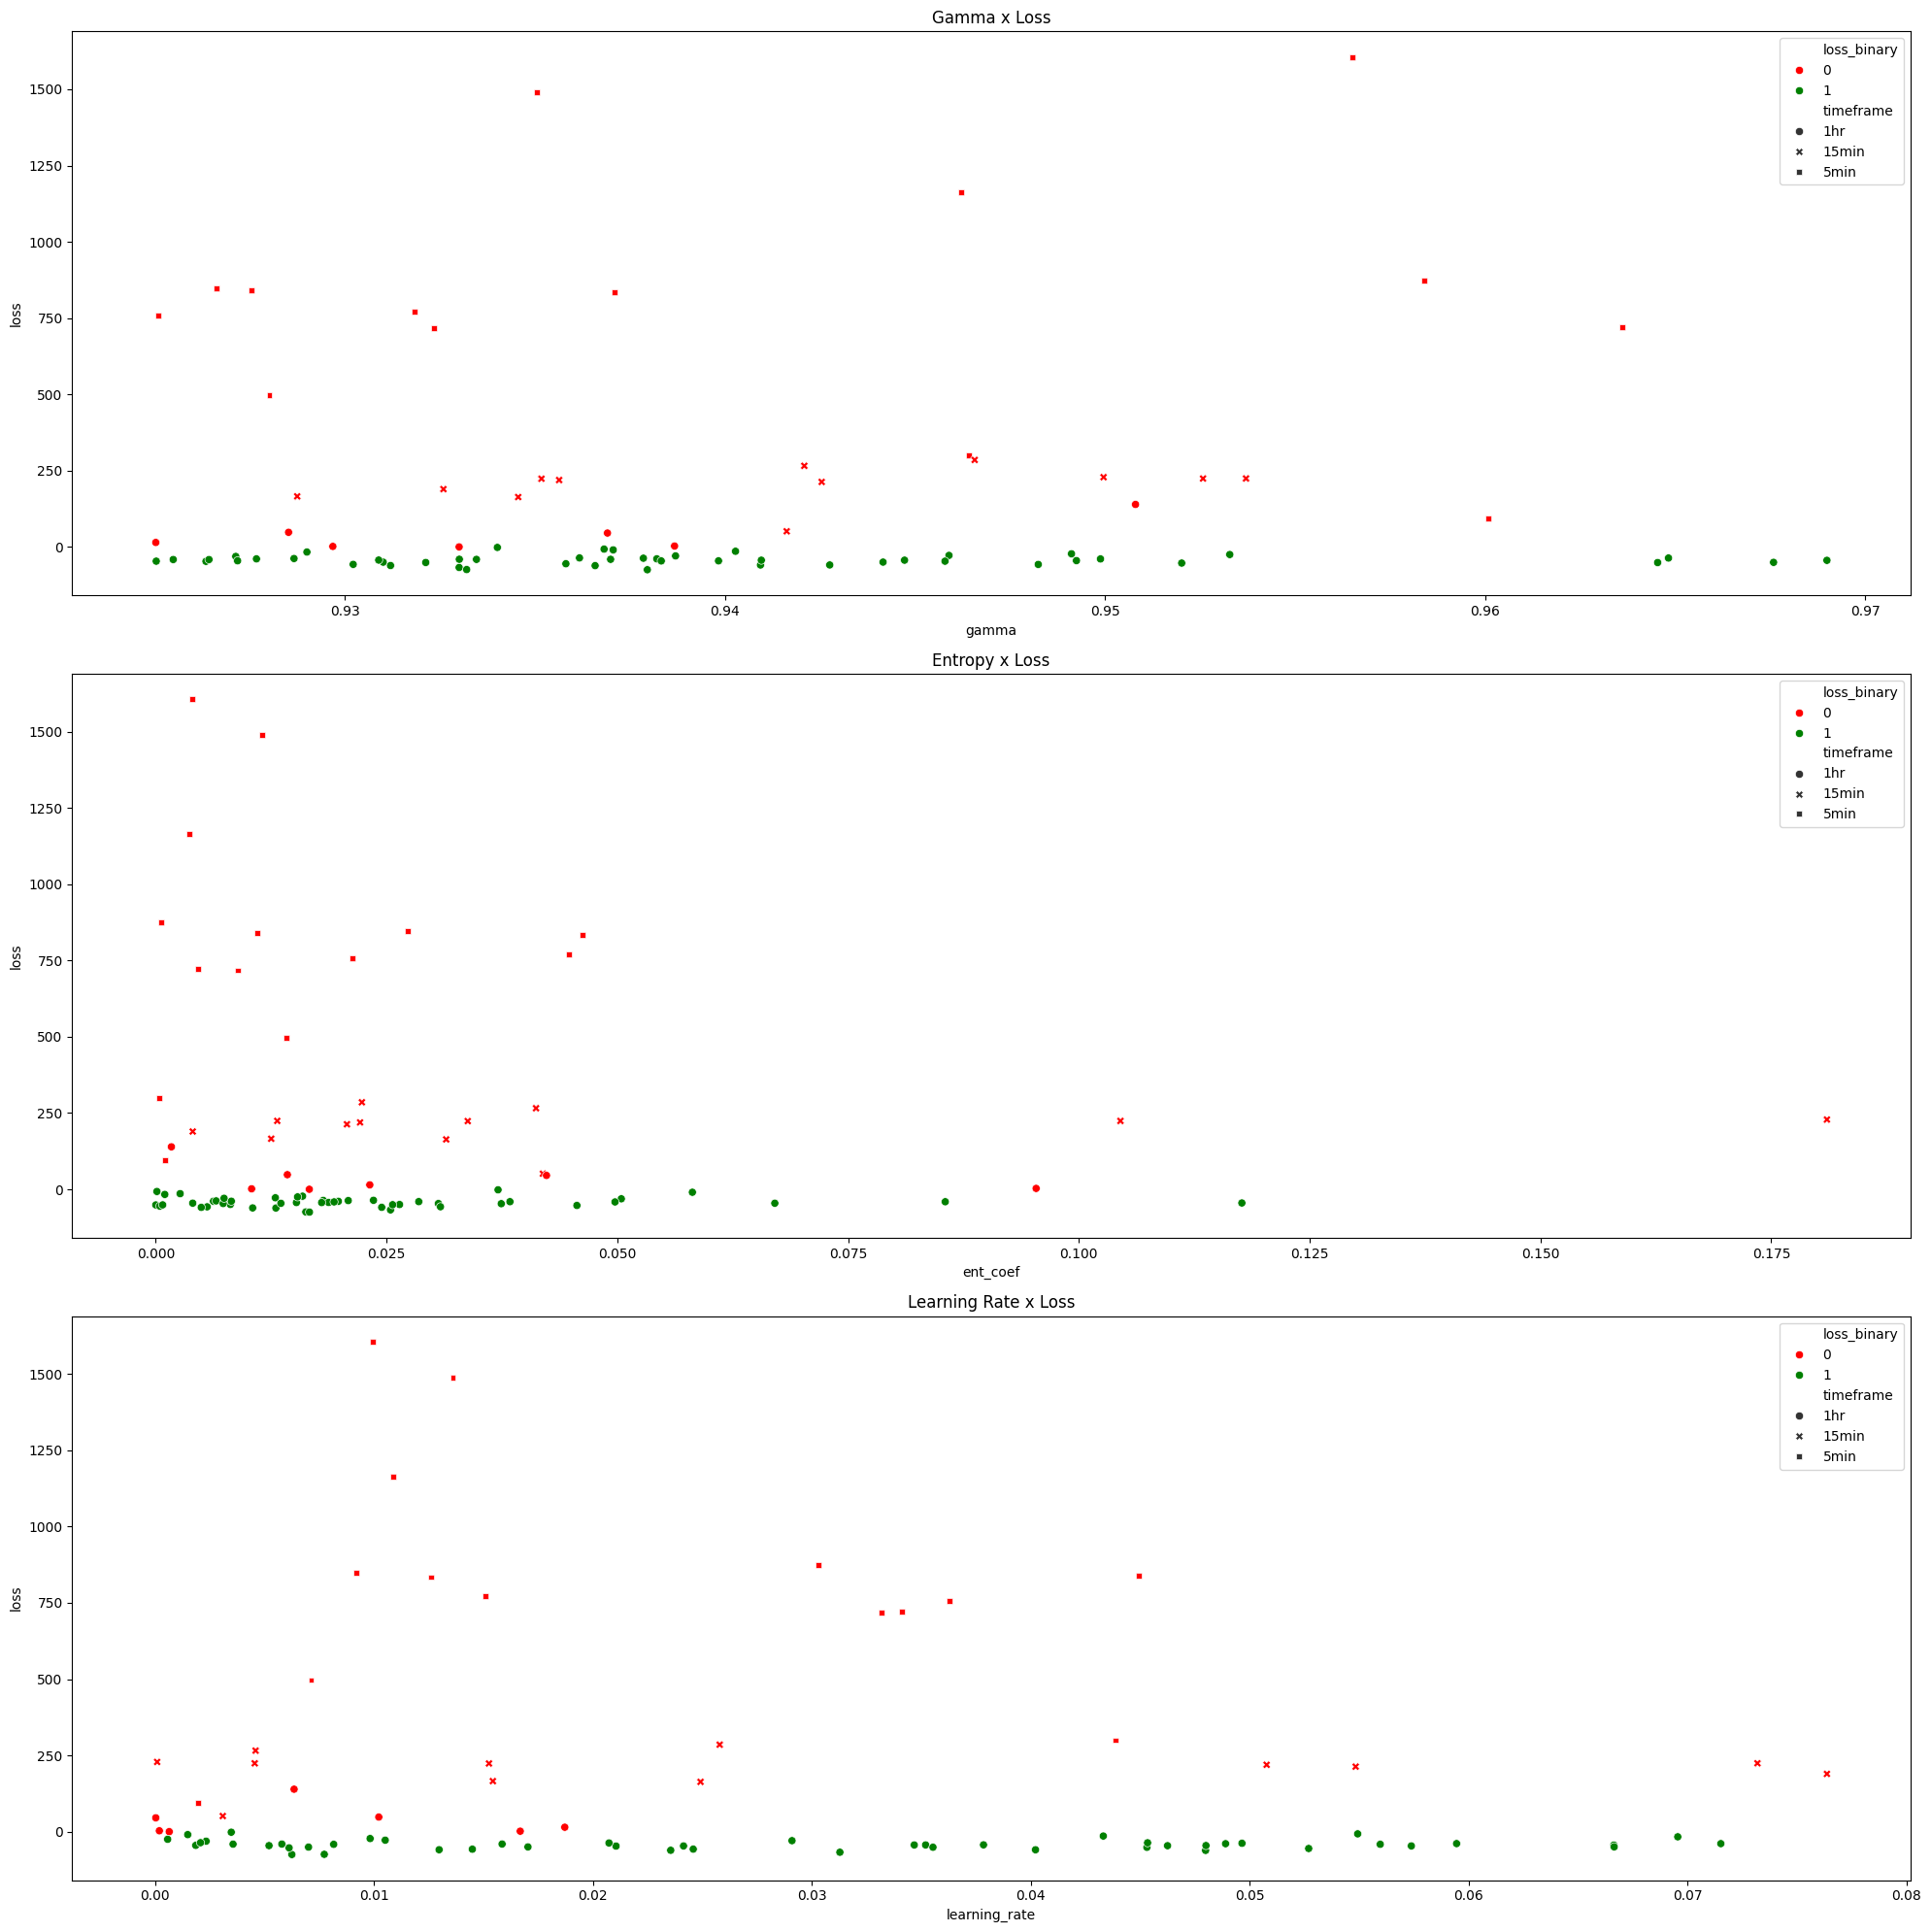

In [32]:
# create 3 figures for the combination of all 3 hyperparameters, learning rate, entropy, and gamma, and I want them stacked with one figure per row and 3 rows to compare the failure distribution of each hyperparameter combination 
# gamma x learning rate, gamma x entropy, learning rate x entropy
# first create the subplot that each figure will go into with 1 column and 3 rows
fig, axs = plt.subplots(3, 1, figsize=(20, 20))
# create the first subplot with gamma x learning rate and loss_binary of ok being green and fail being red 
sns.scatterplot(data=results_df, x='gamma', y='loss', hue='loss_binary', ax=axs[0], palette=custom_palette, style='timeframe')
axs[0].set_title('Gamma x Loss')
# create the second subplot with gamma x entropy and loss_binary of ok being green and fail being red
sns.scatterplot(data=results_df, x='ent_coef', y='loss', hue='loss_binary', ax=axs[1], palette=custom_palette, style='timeframe')
axs[1].set_title('Entropy x Loss')
# create the third subplot with learning rate x entropy and loss_binary of ok being green and fail being red
sns.scatterplot(data=results_df, x='learning_rate', y='loss', hue='loss_binary', ax=axs[2], palette=custom_palette, style='timeframe')
axs[2].set_title('Learning Rate x Loss')
# add some space between each figure
plt.tight_layout()
# plot the figure
plt.show()

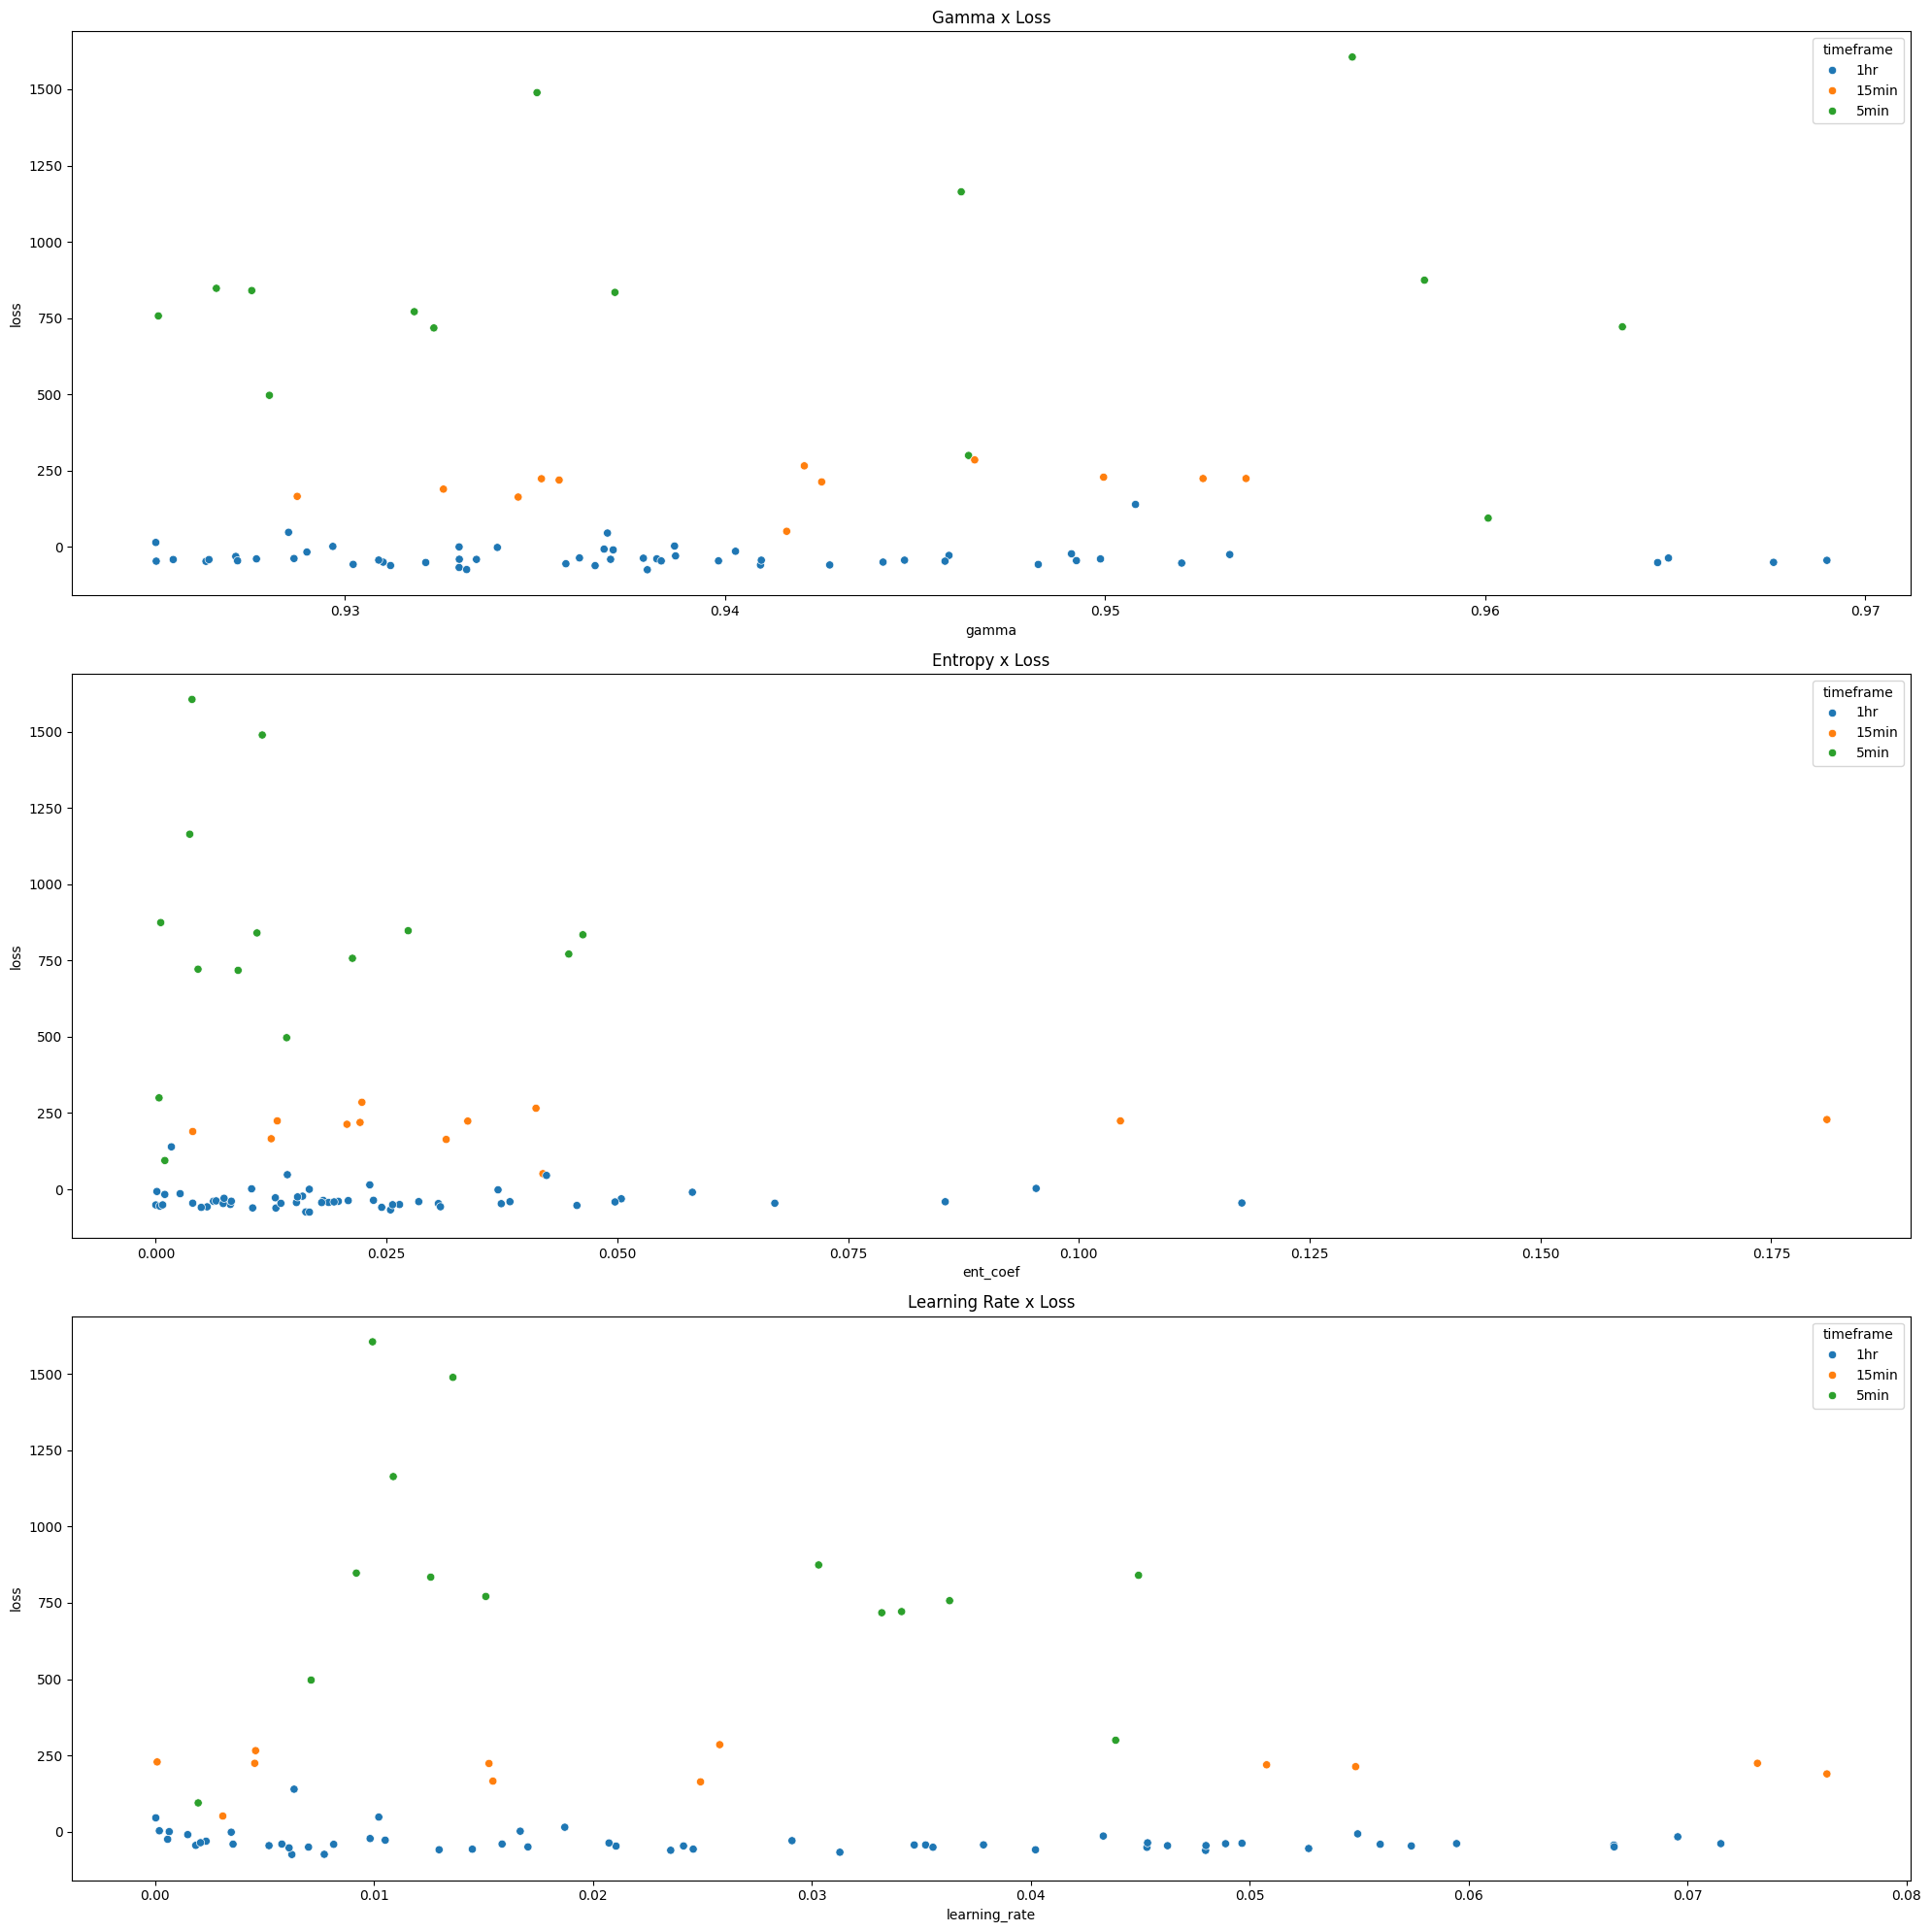

In [34]:
# create 3 figures for the combination of all 3 hyperparameters, learning rate, entropy, and gamma, and I want them stacked with one figure per row and 3 rows to compare the failure distribution of each hyperparameter combination 
# gamma x learning rate, gamma x entropy, learning rate x entropy
# first create the subplot that each figure will go into with 1 column and 3 rows
fig, axs = plt.subplots(3, 1, figsize=(20, 20))
# create the first subplot with gamma x learning rate and reward of ok being green and fail being red
sns.scatterplot(data=results_df_success, x='gamma', y='loss', hue='timeframe', ax=axs[0])#, palette=custom_palette)
axs[0].set_title('Gamma x Loss')
# create the second subplot with gamma x entropy and reward of ok being green and fail being red
sns.scatterplot(data=results_df_success, x='ent_coef', y='loss', hue='timeframe', ax=axs[1])#, palette=custom_palette)
axs[1].set_title('Entropy x Loss')
# create the third subplot with learning rate x entropy and reward of ok being green and fail being red
sns.scatterplot(data=results_df_success, x='learning_rate', y='loss', hue='timeframe', ax=axs[2])#, palette=custom_palette)
axs[2].set_title('Learning Rate x Loss')
# add some space between each figure
plt.tight_layout()
# plot the figure
plt.show()

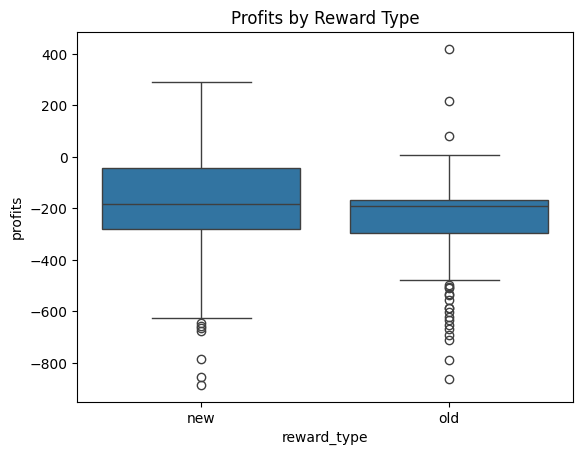

<Figure size 2000x1000 with 0 Axes>

In [34]:
# create a boxplot showing the profits versus old or new reward_type
sns.boxplot(data=results_df, x='reward_type', y='profits')
plt.title('Profits by Reward Type')
# increase the figure size
plt.figure(figsize=(20, 10))
plt.show()

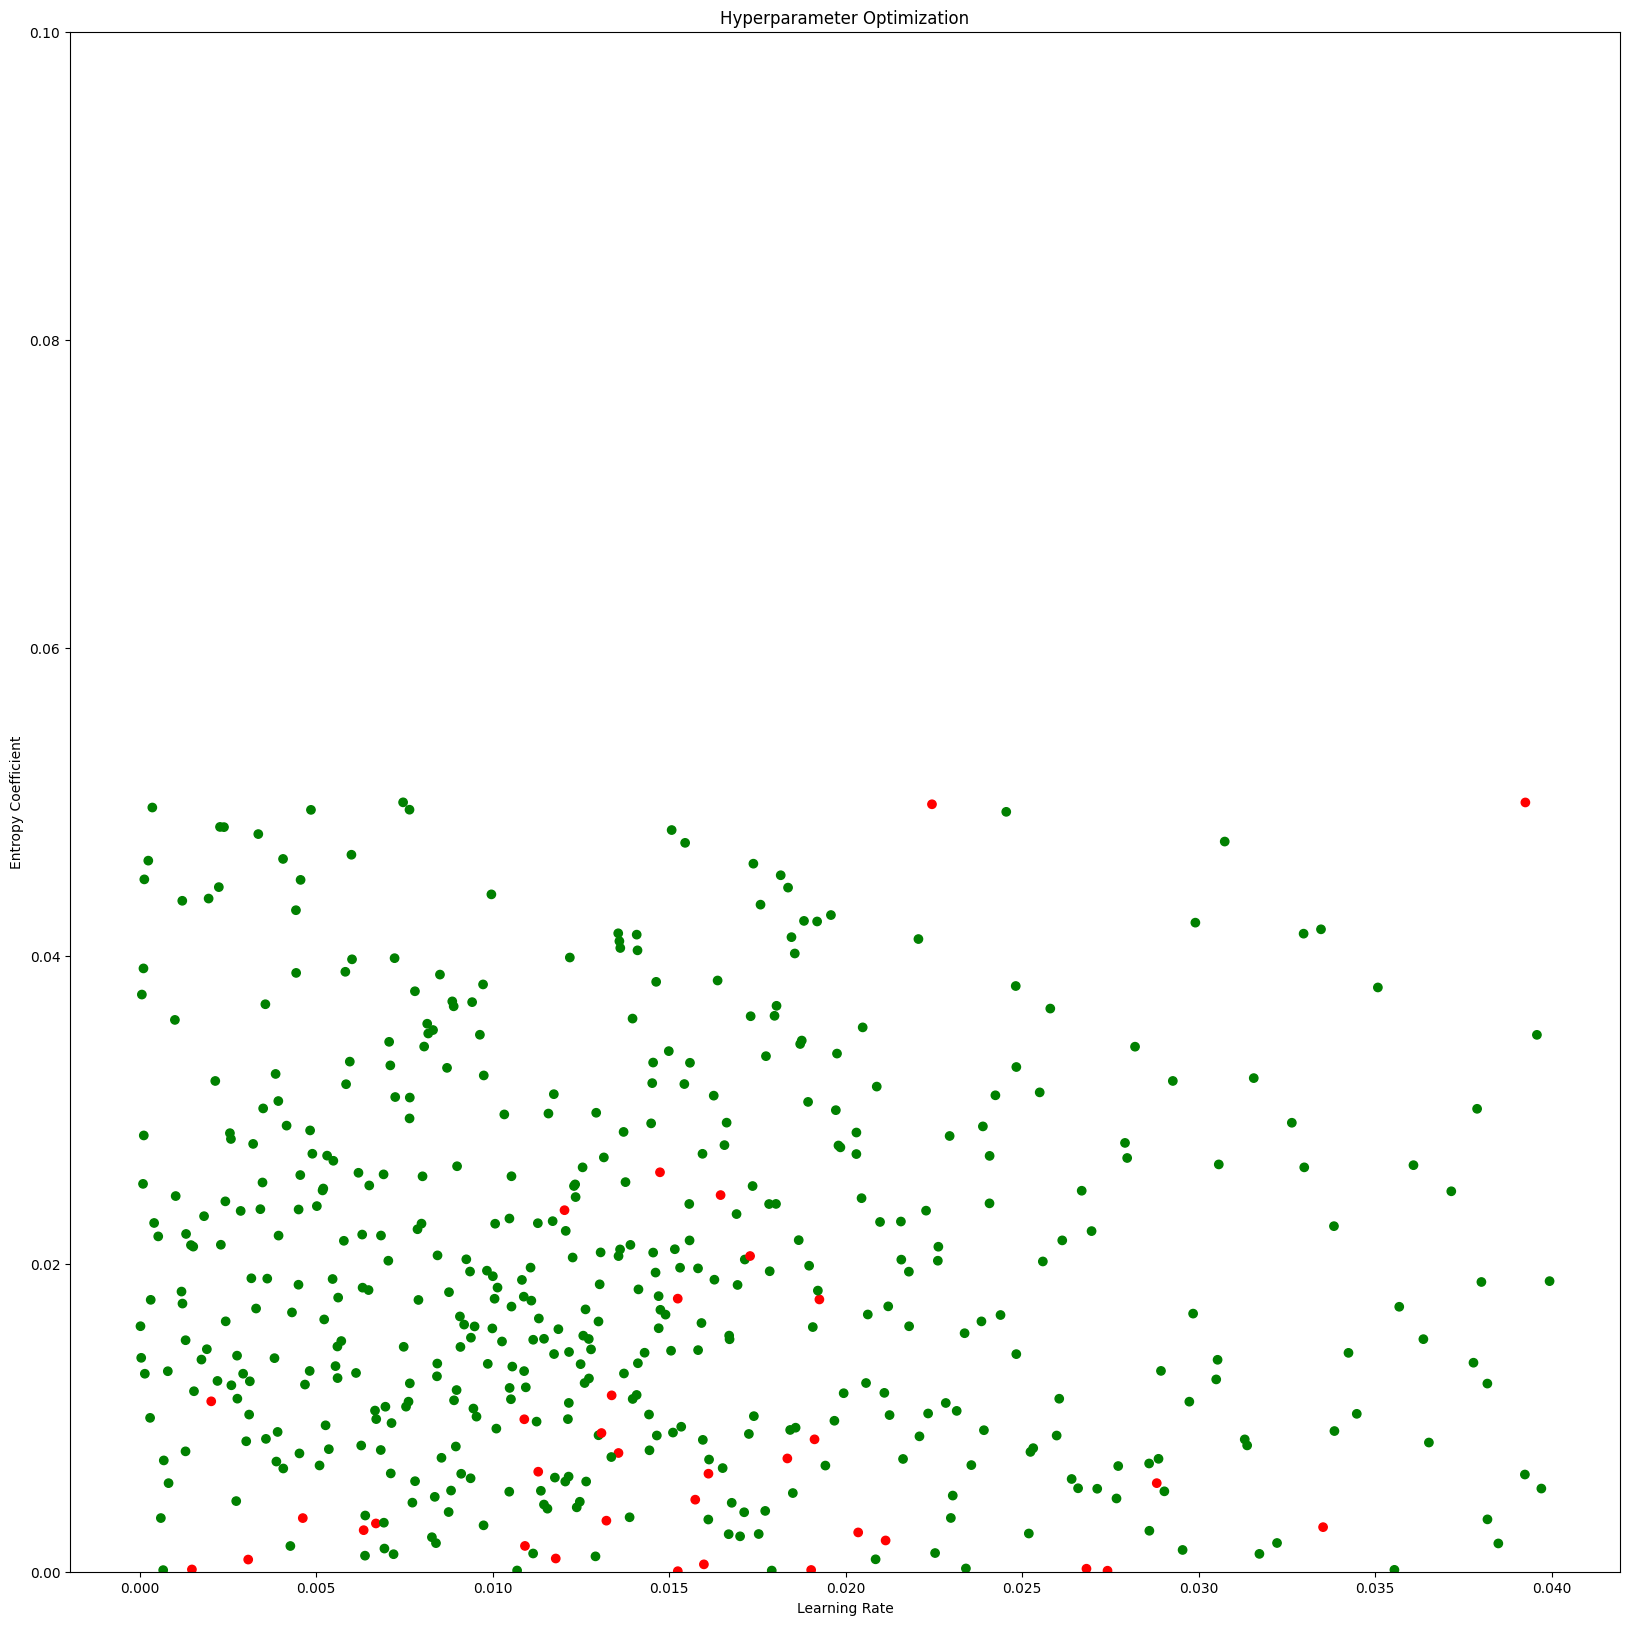

In [34]:
# visualize the parameters that cause failures in the objective function

# create a graph that has learning rate on the x-axis and ent_coef on the y-axis, 
# then the color of the points is whether the status is ok or fail, green for ok and red for fail

fig, ax = plt.subplots()
scatter = ax.scatter(results_df['learning_rate'], results_df['ent_coef'], 
                     c=results_df['status'].apply(lambda x: 'green' if x == 'ok' else 'red'))
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Entropy Coefficient')
ax.set_title('Hyperparameter Optimization')
# y lim to 0.2
plt.ylim(0, 0.1)
# x lim to 0.05
# plt.xlim(0, 0.05)
# plt.legend(handles=scatter.legend_elements()[0], labels=['OK', 'Fail'])
# increase the plot size
fig.set_size_inches(20, 20)
plt.show()


# Best Hyperparameters vs Next Week

In [35]:
# only successes 
results_df_success = results_df[results_df['status'] == 'ok']
results_df_success_negative = results_df_success[results_df_success['loss'] < 0]
# sort values from least to greatest loss
results_df_success_negative_sorted = results_df_success_negative.sort_values(by='loss', ascending=True)
results_df_success_negative_sorted

,loss,status,volume,learning_rate,ent_coef,gamma,orders,profits,loss_binary
107,-10.831816,ok,new,0.012265,0.020404,0.952137,6.9,76.150001,1
197,-6.451969,ok,new,0.012604,0.012253,0.939884,4.1,36.680656,1
40,-5.996958,ok,new,0.012131,0.009909,0.964680,2.4,183.314193,1
172,-5.679781,ok,new,0.012336,0.025151,0.967170,2.3,351.351914,1
89,-4.635464,ok,new,0.018026,0.023883,0.974811,10.7,470.284997,1
...,...,...,...,...,...,...,...,...,...
256,-0.003992,ok,old,0.004501,0.023521,0.937636,48.0,-766.357725,1
436,-0.003931,ok,old,0.008436,0.020541,0.926093,52.0,-3365.031926,1
408,-0.003782,ok,old,0.008393,0.001856,0.943540,35.3,-287.507237,1
347,-0.003274,ok,old,0.008277,0.002241,0.970721,40.7,-295.371799,1


In [52]:
env_train = MyMtEnv(
    original_simulator=sim_train,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(symbols[1]['EURUSD'].loc[:(max_friday - pd.DateOffset(days=7)), :].index),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [54]:
seed = 2024  # random seed
total_num_episodes = 10

# print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

seed                     : 2024


In [63]:
def objective_testing(params):
    learning_timesteps = 50 #params['learning_timesteps']
    ent_coef = params['ent_coef']
    gamma = params['gamma'] #0.99 #
    learning_rate = params['learning_rate']#0.0003#

    total_learning_timesteps = learning_timesteps * 1000
    step_key = f'{learning_timesteps}K'
    policy_dict = PPO.policy_aliases
    policy = policy_dict.get('MultiInputPolicy')
    class_name = type(PPO).__qualname__
    plot_key = f'{class_name}_rewards_'+step_key
    try:
        rewards, orders, profits = train_val_model(PPO, policy, env_train, env_testing, seed, step_key,  
                                                    learning_rate, gamma, ent_coef, total_learning_timesteps)
    except Exception as e:
        print(f'''there was an error {e} with those parameters: timesteps: {learning_timesteps}, \n
              ent_coef: {ent_coef}, gamma: {gamma}, learning_rate: {learning_rate}''')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    # timesteps_models_dict[step_key] = models_dict
    min_rewards, avg_rewards, max_rewards, = print_stats(rewards, 'Reward')
    print_stats(orders, 'Orders')
    label = f'Avg. {avg_rewards:>7.2f} : {class_name} - {step_key}'
    plot_data[plot_key] = rewards
    plot_settings[plot_key] = {'label': label}
    params['avg_orders'] = np.mean(orders)      
    params['profits'] = np.mean(profits)    

    return {'loss': -avg_rewards, 'status': STATUS_OK, 'eval_time': time.time(), 'parameters': params}

## Results for best models from hyperparameter search

In [67]:
# how does the model perform on the following week
hyperparameter_tune_weekly_result_next_week_new = []
results_df_success_negative_no_zero = results_df_success_negative_sorted[results_df_success_negative_sorted['volume'] == 'new']
# filter to just the top 10 
results_df_success_negative_no_zero = results_df_success_negative_no_zero.iloc[:10, :]
results_df_success_negative_no_zero

,loss,status,volume,learning_rate,ent_coef,gamma,orders,profits,loss_binary
107,-10.831816,ok,new,0.012265,0.020404,0.952137,6.9,76.150001,1
197,-6.451969,ok,new,0.012604,0.012253,0.939884,4.1,36.680656,1
40,-5.996958,ok,new,0.012131,0.009909,0.964680,2.4,183.314193,1
172,-5.679781,ok,new,0.012336,0.025151,0.967170,2.3,351.351914,1
89,-4.635464,ok,new,0.018026,0.023883,0.974811,10.7,470.284997,1
145,-3.118632,ok,new,0.022534,0.001213,0.958459,1.2,-13.308169,1
206,-3.084172,ok,new,0.016129,0.007284,0.941556,7.3,-0.539169,1
212,-2.450440,ok,new,0.013608,0.020928,0.943344,12.0,159.594924,1
52,-2.207924,ok,new,0.028604,0.002659,0.957624,4.1,191.607996,1
51,-1.747056,ok,new,0.016108,0.003389,0.957758,9.4,103.983516,1


In [68]:
for row in range(0, len(results_df_success_negative_no_zero)):
    print(f"{'-'*40} loss: {round(results_df_success_negative_no_zero.iloc[row, 0], 2)} {'-'*40}")
    # i = results_df_success_negative_no_zero.iloc[row, 3] - 7    
    parameters = {
        'learning_rate': results_df_success_negative_no_zero.iloc[row, 3],
        'ent_coef': results_df_success_negative_no_zero.iloc[row, 4],
        'gamma': results_df_success_negative_no_zero.iloc[row, 5]
    }
    result = objective_testing(parameters)
    hyperparameter_tune_weekly_result_next_week_new.append(result)
    # print(result)

---------------------------------------- loss: -10.83 ----------------------------------------
--------------------------------------------------------------------------------
entropy: 0.020403648737824215, learning rate: 0.012265210841725424, gamma: 0.9521367983439578
Episode: 0, Avg. Reward: 4.226, # of orders: 11.000, avg Profit: 113.503
Episode: 1, Avg. Reward: 1.949, # of orders: 11.500, avg Profit: 47.632
Episode: 2, Avg. Reward: 1.094, # of orders: 11.667, avg Profit: 22.731
Episode: 3, Avg. Reward: 0.639, # of orders: 12.000, avg Profit: 6.899
Episode: 4, Avg. Reward: 0.562, # of orders: 12.400, avg Profit: 8.375
Episode: 5, Avg. Reward: 0.712, # of orders: 11.333, avg Profit: 10.197
Episode: 6, Avg. Reward: 0.498, # of orders: 12.143, avg Profit: -5.659
Episode: 7, Avg. Reward: 0.351, # of orders: 12.250, avg Profit: -11.533
Episode: 8, Avg. Reward: 0.342, # of orders: 13.556, avg Profit: -8.755
Episode: 9, Avg. Reward: 0.245, # of orders: 13.200, avg Profit: -10.876
Min. Rewa

In [45]:
env_train = gym_mtsim.MtEnv(
    original_simulator=sim_train,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(symbols[1]['EURUSD'].loc[:(max_friday - pd.DateOffset(days=7)), :].index),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

sim_testing = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_testing = gym_mtsim.MtEnv(
    original_simulator=sim_testing,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(testing_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [51]:
# how does the model perform on the following week
hyperparameter_tune_weekly_result_next_week_old = []
results_df_success_negative_no_zero_old = results_df_success_negative_sorted[results_df_success_negative_sorted['volume'] == 'old']
# filter to just the top 10 
results_df_success_negative_no_zero_old = results_df_success_negative_no_zero_old.iloc[:10, :]
for row in range(0, len(results_df_success_negative_no_zero_old)):
    print(f"{'-'*40} loss: {round(results_df_success_negative_no_zero_old.iloc[row, 0], 2)} {'-'*40}")
    # i = results_df_success_negative_no_zero_old.iloc[row, 3] - 7    
    parameters = {
        'learning_rate': results_df_success_negative_no_zero_old.iloc[row, 3],
        'ent_coef': results_df_success_negative_no_zero_old.iloc[row, 4],
        'gamma': results_df_success_negative_no_zero_old.iloc[row, 5]
    }
    result = objective_testing(parameters)
    hyperparameter_tune_weekly_result_next_week_old.append(result)
    # print(result)

---------------------------------------- loss: -3.09 ----------------------------------------
--------------------------------------------------------------------------------
entropy: 0.007397446870327936, learning rate: 0.008548519188811199, gamma: 0.9293254569719144
Episode: 0, Avg. Reward: 2.549, # of orders: 11.000, avg Profit: 697.974
Episode: 1, Avg. Reward: 1.356, # of orders: 11.500, avg Profit: 380.611
Episode: 2, Avg. Reward: 1.704, # of orders: 11.333, avg Profit: 421.482
Episode: 3, Avg. Reward: 1.138, # of orders: 11.750, avg Profit: 263.763
Episode: 4, Avg. Reward: 1.420, # of orders: 12.200, avg Profit: 466.858
Episode: 5, Avg. Reward: 1.380, # of orders: 11.167, avg Profit: 427.296
Episode: 6, Avg. Reward: 1.316, # of orders: 11.857, avg Profit: 428.874
Episode: 7, Avg. Reward: 1.034, # of orders: 12.000, avg Profit: 302.857
Episode: 8, Avg. Reward: 0.972, # of orders: 13.111, avg Profit: 292.305
Episode: 9, Avg. Reward: 0.804, # of orders: 12.800, avg Profit: 230.851
M

In [69]:
for result in hyperparameter_tune_weekly_result_next_week_old:
    result['volume'] = 'old'
for result in hyperparameter_tune_weekly_result_next_week_new:
    result['volume'] = 'new'
hyperparameter_next_week_results = hyperparameter_tune_weekly_result_next_week_old + hyperparameter_tune_weekly_result_next_week_new
hyperparameter_next_week_results

[{'loss': -0.8044031917590935,
  'status': 'ok',
  'eval_time': 1715084875.997915,
  'parameters': {'learning_rate': 0.008548519188811199,
   'ent_coef': 0.007397446870327936,
   'gamma': 0.9293254569719144,
   'avg_orders': 12.8,
   'profits': 230.85056125557108},
  'volume': 'old'},
 {'loss': 0.03897180229338384,
  'status': 'ok',
  'eval_time': 1715085005.6909807,
  'parameters': {'learning_rate': 0.0027565532104863568,
   'ent_coef': 0.014030426979679864,
   'gamma': 0.9531560117749693,
   'avg_orders': 21.3,
   'profits': -107.89848960393276},
  'volume': 'old'},
 {'loss': None,
  'status': 'fail',
  'eval_time': 1715085152.8910143,
  'parameters': {'learning_rate': 0.014649561614036376,
   'ent_coef': 0.00884549317169073,
   'gamma': 0.9504952893136831},
  'volume': 'old'},
 {'loss': -0.916987093609103,
  'status': 'ok',
  'eval_time': 1715085446.2582536,
  'parameters': {'learning_rate': 0.003612573080489734,
   'ent_coef': 0.019032790945864096,
   'gamma': 0.9435445127610409,
 

In [70]:
results_df_hyperparameter_tuned = pd.DataFrame()
new_dict = {}
for idx, result in enumerate(hyperparameter_next_week_results):
    new_dict['loss'] = result['loss']
    new_dict['status'] = result['status']
    new_dict['volume'] = result['volume']
    new_dict['learning_rate'] = result['parameters']['learning_rate']
    new_dict['ent_coef'] = result['parameters']['ent_coef']
    new_dict['gamma'] = result['parameters']['gamma']
    try:
        new_dict['orders'] = result['parameters']['avg_orders']
        new_dict['profits'] = result['parameters']['profits']
    except: 
        new_dict['orders'] = 0
        new_dict['profits'] = 0
    new_row = pd.DataFrame(new_dict, index=[idx])
    results_df_hyperparameter_tuned = pd.concat([results_df_hyperparameter_tuned, new_row], axis=0)
results_df_hyperparameter_tuned


,loss,status,volume,learning_rate,ent_coef,gamma,orders,profits
0,-0.804403,ok,old,0.008549,0.007397,0.929325,12.8,230.850561
1,0.038972,ok,old,0.002757,0.014030,0.953156,21.3,-107.898490
2,NaN,fail,old,0.014650,0.008845,0.950495,0.0,0.000000
3,-0.916987,ok,old,0.003613,0.019033,0.943545,11.1,338.492463
4,-0.368428,ok,old,0.001951,0.043712,0.947370,1.5,76.532645
5,-0.183091,ok,old,0.008820,0.005271,0.946751,66.4,378.057088
6,0.045996,ok,old,0.005464,0.019007,0.940933,5.7,-68.014322
7,-0.593048,ok,old,0.009383,0.015198,0.927543,17.9,213.285215
8,-0.230112,ok,old,0.007191,0.001138,0.954842,2.5,87.878679
9,-0.605583,ok,old,0.003871,0.007154,0.958755,24.2,327.085868


In [71]:
results_df_hyperparameter_tuned.loc[:, 'loss_binary'] = np.where(results_df_hyperparameter_tuned['loss'] < 0, 1, 0)

In [72]:
# select only 'loss', 'entropy', gamma, and learning rate from results_df_success_negative_sorted
results_df_success_negative_sorted_sel = results_df_success_negative_sorted.loc[:, ['loss', 'ent_coef', 'gamma', 'learning_rate']]
# rename loss to loss_original
results_df_success_negative_sorted_sel = results_df_success_negative_sorted_sel.rename(columns={'loss': 'loss_original'})
# join results_df_success_negative_sorted_sel on 'entropy', gamma, and learning rate with results_df_hyperparameter_tuned
print(len(results_df_hyperparameter_tuned))
results_df_hyperparameter_tuned_joined = results_df_hyperparameter_tuned.merge(results_df_success_negative_sorted_sel, how='inner', on=['ent_coef', 'gamma', 'learning_rate']) #, right_on=['ent_coef', 'gamma', 'learning_rate']
print(len(results_df_hyperparameter_tuned_joined))
results_df_hyperparameter_tuned_joined

20
20


,loss,status,volume,learning_rate,ent_coef,gamma,orders,profits,loss_binary,loss_original
0,-0.804403,ok,old,0.008549,0.007397,0.929325,12.8,230.850561,1,-3.093495
1,0.038972,ok,old,0.002757,0.014030,0.953156,21.3,-107.898490,0,-1.679196
2,NaN,fail,old,0.014650,0.008845,0.950495,0.0,0.000000,0,-1.592541
3,-0.916987,ok,old,0.003613,0.019033,0.943545,11.1,338.492463,1,-1.050247
4,-0.368428,ok,old,0.001951,0.043712,0.947370,1.5,76.532645,1,-0.925284
5,-0.183091,ok,old,0.008820,0.005271,0.946751,66.4,378.057088,1,-0.562863
6,0.045996,ok,old,0.005464,0.019007,0.940933,5.7,-68.014322,0,-0.499335
7,-0.593048,ok,old,0.009383,0.015198,0.927543,17.9,213.285215,1,-0.482738
8,-0.230112,ok,old,0.007191,0.001138,0.954842,2.5,87.878679,1,-0.390152
9,-0.605583,ok,old,0.003871,0.007154,0.958755,24.2,327.085868,1,-0.353470


In [73]:
results_df_hyperparameter_tuned_joined.groupby('volume').count()

,loss,status,learning_rate,ent_coef,gamma,orders,profits,loss_binary,loss_original
volume,,,,,,,,,
new,10,10,10,10,10,10,10,10,10
old,9,10,10,10,10,10,10,10,10


In [ ]:
results_df_hyperparameter_tuned.to_excel('best_hyperparameter_search_results.xlsx', index=False)

In [33]:
# results_df_hyperparameter_tuned.to_excel('best_hyperparameter_search_results.xlsx', index=False)

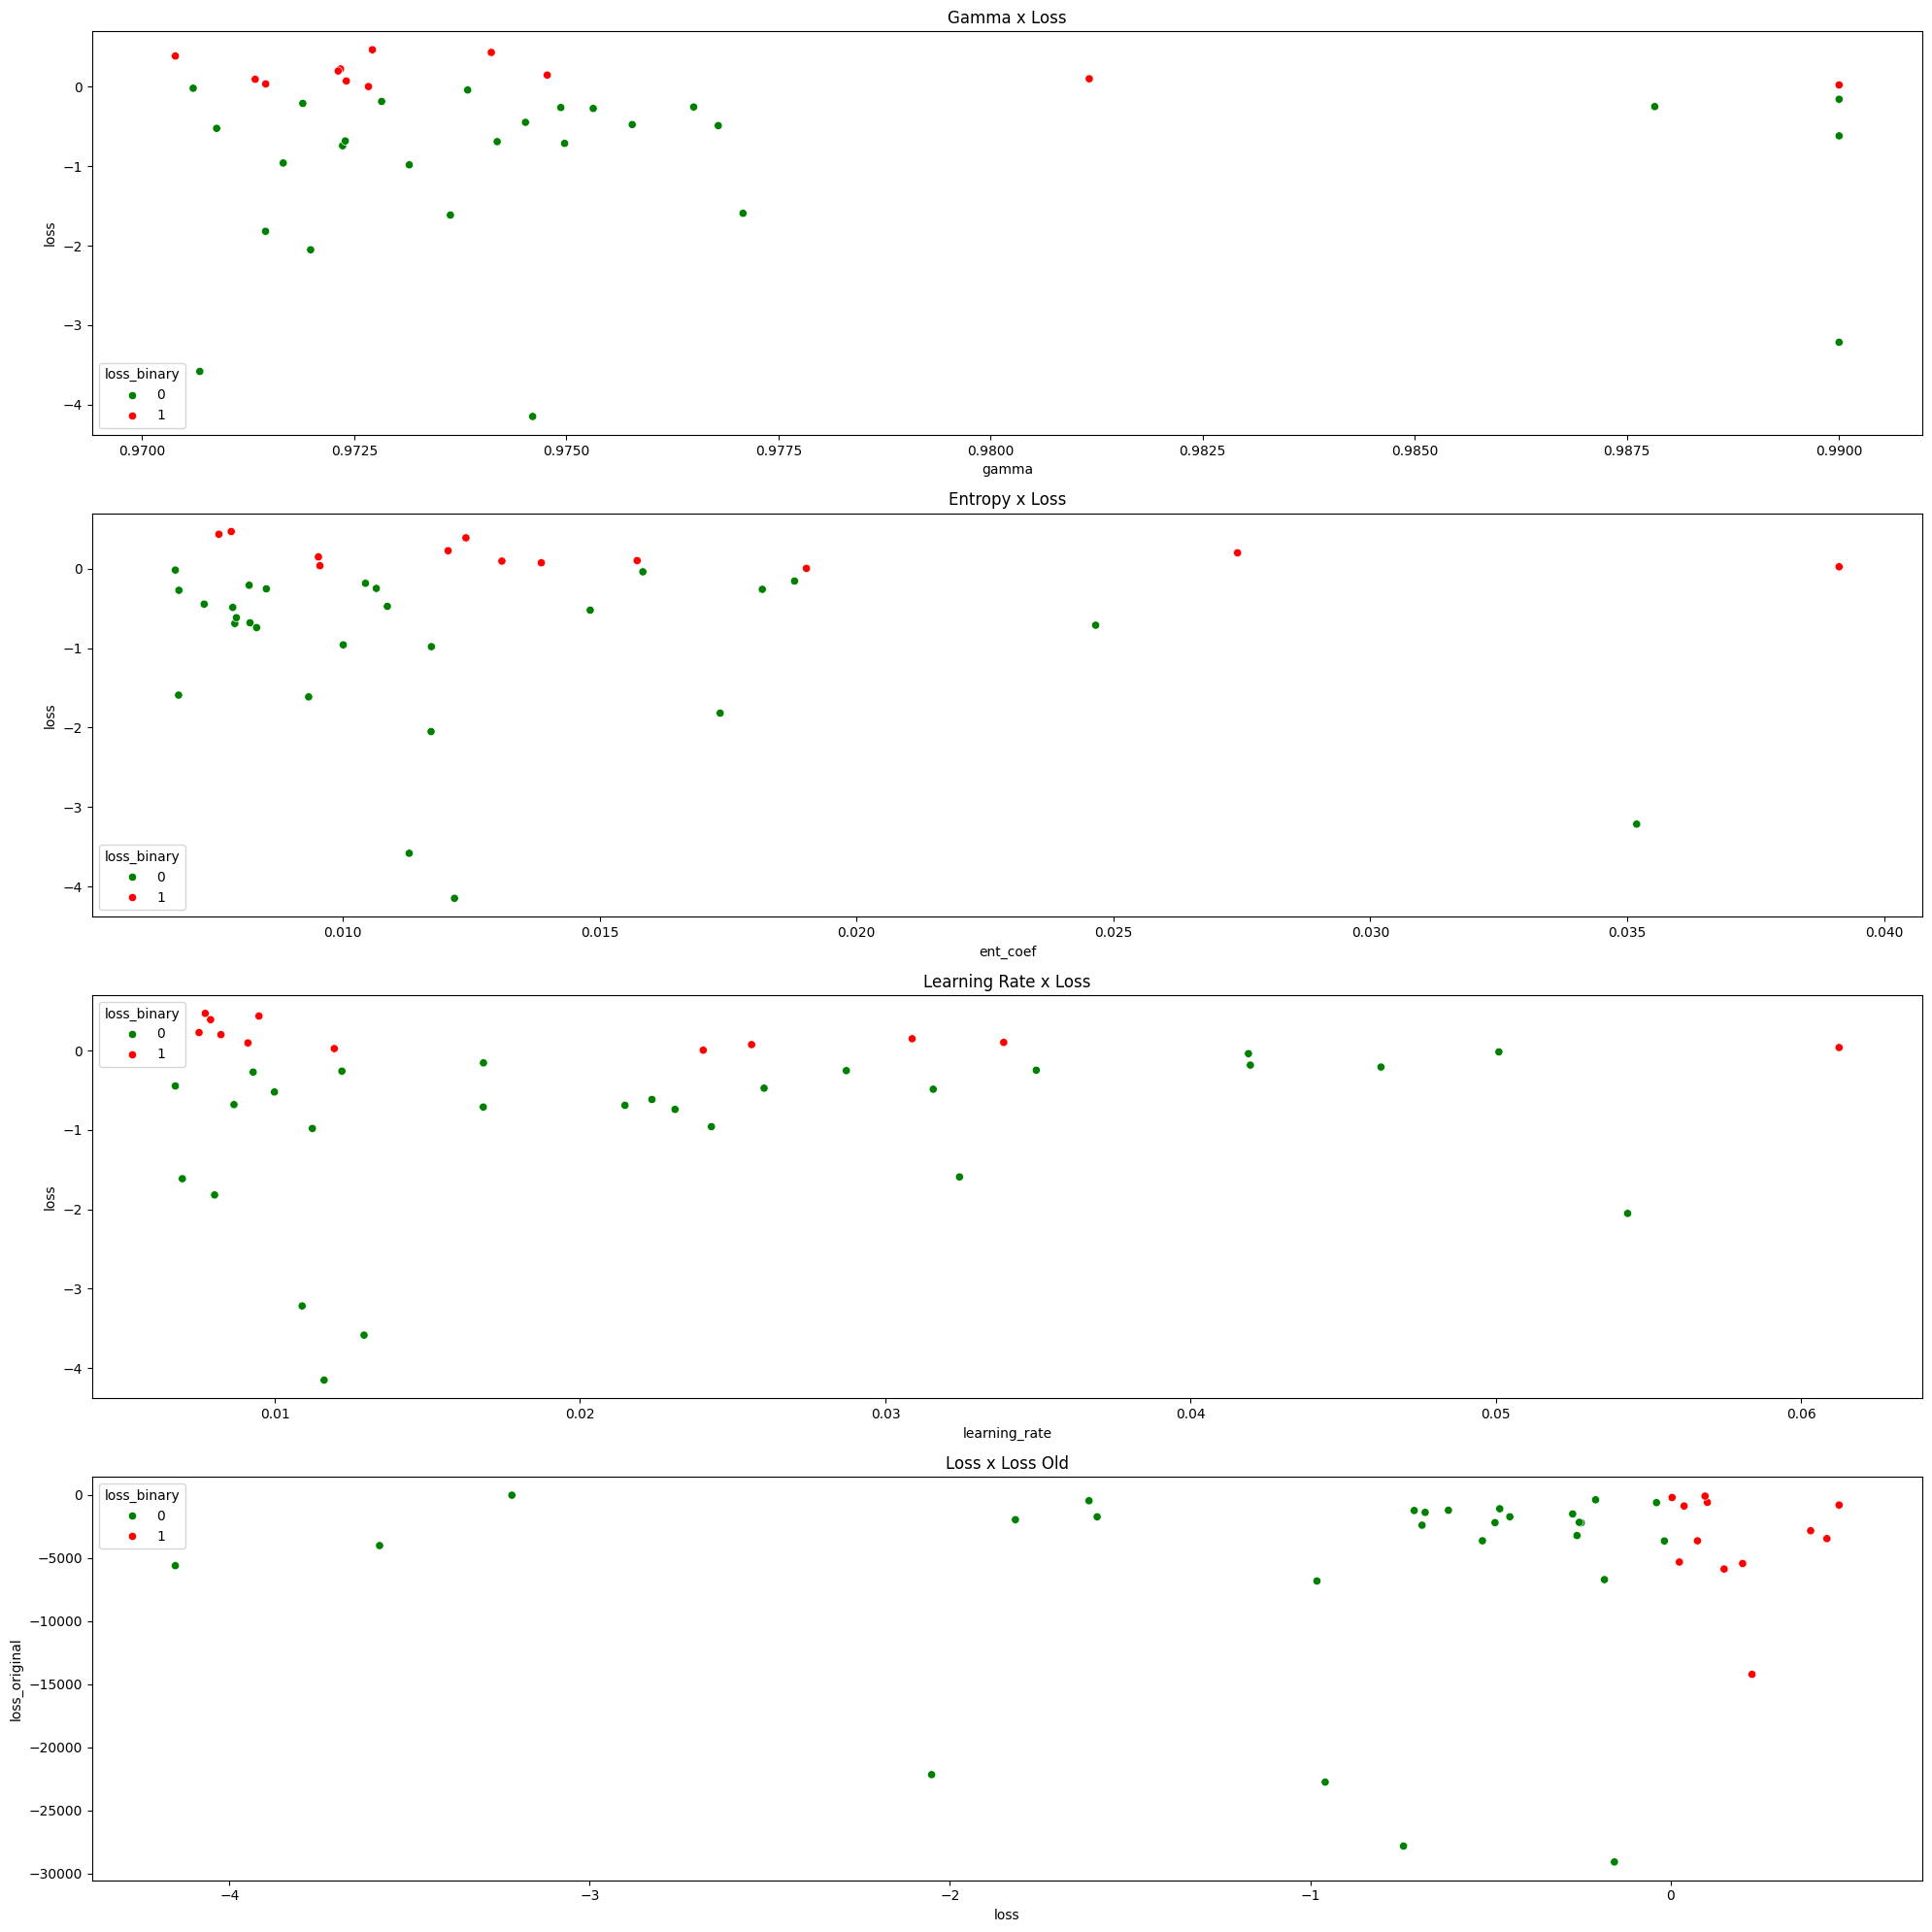

In [54]:
# create 3 figures for the combination of all 3 hyperparameters, learning rate, entropy, and gamma, and I want them stacked with one figure per row and 3 rows to compare the failure distribution of each hyperparameter combination 
# gamma x learning rate, gamma x entropy, learning rate x entropy
# first create the subplot that each figure will go into with 1 column and 3 rows
fig, axs = plt.subplots(4, 1, figsize=(20, 20))
# create the first subplot with gamma x learning rate and loss_binary of ok being green and fail being red
sns.scatterplot(data=results_df_hyperparameter_tuned_joined, x='gamma', y='loss', hue='loss_binary', ax=axs[0], palette=custom_palette)
axs[0].set_title('Gamma x Loss')
# create the second subplot with gamma x entropy and loss_binary of ok being green and fail being red
sns.scatterplot(data=results_df_hyperparameter_tuned_joined, x='ent_coef', y='loss', hue='loss_binary', ax=axs[1], palette=custom_palette)
axs[1].set_title('Entropy x Loss')
# create the third subplot with learning rate x entropy and loss_binary of ok being green and fail being red
sns.scatterplot(data=results_df_hyperparameter_tuned_joined, x='learning_rate', y='loss', hue='loss_binary', ax=axs[2], palette=custom_palette)
axs[2].set_title('Learning Rate x Loss')
# comparing the original loss to new loss
sns.scatterplot(data=results_df_hyperparameter_tuned_joined, x='loss', y='loss_original', hue='loss_binary', ax=axs[3], palette=custom_palette)
axs[3].set_title('Loss x Loss Old')
# add some space between each figure
plt.tight_layout()
# plot the figure
plt.show()

In [ ]:
lr = results_df_success_negative_sorted.iloc[1,4]
entropy = results_df_success_negative_sorted.iloc[1,5]
gamma = results_df_success_negative_sorted.iloc[1,6]

In [ ]:
seed = 2024
rewards, orders = train_val_model(PPO, 'MultiInputPolicy', env_train, env_testing, seed, '50K',  
                                                    lr, gamma, entropy, 250_000)

In [ ]:
rewards

In [ ]:
# Assuming env_orders is your DataFrame and 'column_name' is the name of the column you want to normalize
orders = env_testing.render()['orders']
# Calculate the mean of the column
mean_value = orders['Volume'].mean()

# Normalize the column to have a mean of 1
orders['Volume_normalized'] = orders['Volume'] / mean_value
orders

In [ ]:
my_profit_calculation(orders, 0.001)

In [ ]:
orders['Volume_normalized'].mean()

In [ ]:
env_testing.render('advanced_figure', time_format="%Y-%m-%d")

In [ ]:
# make a sound when the code is done
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 2000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [ ]:
# generate a 3d plot of the learning rate, ent_coef, and loss
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = results_df_success_negative['learning_rate']
y = results_df_success_negative['loss']
z = results_df_success_negative['ent_coef']

ax.scatter(x, y, z, c=z, cmap='viridis')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Loss')
ax.set_zlabel('Entropy Coefficient')

# increase the plot size
fig.set_size_inches(20, 20)

plt.show()


In [ ]:
# generate a 3d plot of the learning rate, ent_coef, and loss
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

results_df_success_negative_low_entropy = results_df_success_negative[results_df_success_negative['ent_coef'] <= 0.2]

x = results_df_success_negative_low_entropy['learning_rate']
y = results_df_success_negative_low_entropy['loss']
z = results_df_success_negative_low_entropy['ent_coef']

ax.scatter(x, y, z, c=z, cmap=cm.coolwarm)

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Loss')
ax.set_zlabel('Entropy Coefficient')



# increase the plot size
fig.set_size_inches(20, 20)

plt.show()


In [ ]:
# visualize the parameters that cause failures in the objective function

# create a graph that has learning rate on the x-axis and ent_coef on the y-axis, 
# then the color of the points is whether the status is ok or fail, green for ok and red for fail

fig, ax = plt.subplots()
scatter = ax.scatter(results_df_success['learning_rate'], results_df_success['ent_coef'], 
                     c=results_df_success['loss'].apply(lambda x: 'green' if x < 0 else 'red'))
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Entropy Coefficient')
ax.set_title('Hyperparameter Optimization')
# plt.legend(handles=scatter.legend_elements()[0], labels=['OK', 'Fail'])
plt.ylim(0, 0.1)
# increase the plot size
fig.set_size_inches(20, 20)
plt.show()


In [ ]:

# create a heatmap with learning rate on the x-axis and ent_coef on the y-axis and the color is the loss
fig, ax = plt.subplots()
scatter = ax.scatter(results_df_success['learning_rate'], results_df_success['ent_coef'], 
                     c=results_df_success['loss'], cmap='viridis')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Entropy Coefficient')
ax.set_title('Hyperparameter Optimization')

plt.colorbar(scatter)
plt.ylim(0, 0.1)
# increase the plot size
fig.set_size_inches(25, 15)
plt.show()


In [ ]:
results_df_success_low_entropy = results_df_success[results_df_success['ent_coef'] <= 0.2]
# create a heatmap with learning rate on the x-axis and ent_coef on the y-axis and the color is the loss
fig, ax = plt.subplots()
scatter = ax.scatter(results_df_success_low_entropy['learning_rate'], results_df_success_low_entropy['loss'], 
                     c=results_df_success_low_entropy['ent_coef'], cmap=cm.coolwarm)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Loss')
ax.set_title('Hyperparameter Optimization')

plt.colorbar(scatter)
# plt.ylim(-50_000, 50_000)
# increase the plot size
fig.set_size_inches(25, 15)
plt.show()


In [ ]:
results_df_success_low_entropy = results_df_success[results_df_success['ent_coef'] <= 0.2]
# create a heatmap with learning rate on the x-axis and ent_coef on the y-axis and the color is the loss
fig, ax = plt.subplots()
scatter = ax.scatter(results_df_success_low_entropy['ent_coef'], results_df_success_low_entropy['loss'], 
                     c=results_df_success_low_entropy['learning_rate'], cmap=cm.coolwarm)
ax.set_xlabel('Entropy Coefficient')
ax.set_ylabel('Loss')
ax.set_title('Hyperparameter Optimization')

plt.colorbar(scatter)
# plt.ylim(-50_000, 50_000)
# increase the plot size
fig.set_size_inches(25, 15)
plt.show()


### Plot Results

In [ ]:
# # create a dataframe of the rewards
# rewards_df = pd.DataFrame({'rewards': rewards})
# # plot the rewards
# plt.figure(figsize=(10, 5))
# sns.lineplot(data=rewards_df)
# plt.title('Rewards')
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.legend()
# plt.show()


In [ ]:
# # import the models from /models folder
# import os
# import glob
# # get the list of models
# model_list = glob.glob('models_4_17_24/*.pkl')
# # separate the strings of each model name on _ and get the last element of the string if the string of the model doesn't include 'initial' or 'updated'
# model_list_episode_nbr = [model.split('_')[-1] for model in model_list if 'initial' not in model and 'updated' not in model]
# model_list_episode_nbr = [int(model_name.split('.')[0]) for model_name in model_list_episode_nbr]
# max_episode = max(model_list_episode_nbr)
# # test the last set of 10 episodes
# init_episode = ((int(max_episode)/10) - 10)*10
# # print(max_episode, init_episode)
# models = []
# # test the last set of 10 episodes from init_episode to max_episode
# for nbr in range(int(init_episode), int(max_episode)+10, 10):
#     # set up the appropriate time_points for each of the models in the list
#     env_train.time_points = list(symbols[1]['EURUSD'].iloc[-int(training_length):-(int(testing_length)-int(nbr)), :].index)# make this -nbr not +nbr next time
#     obs_train, info_train = env_train.reset(seed=2024)
#     # find the model name that contains the nbr
#     model_name = [model for model in model_list if str(nbr) in model][0]
#     print(model_name)
#     # load the models into a list
#     models.append(PPO.load(model_name, env=env_train))

In [ ]:
# sim_testing = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH
# )

# env_testing = MtEnv(
#     original_simulator=sim_testing,
#     trading_symbols=['EURUSD'],
#     window_size = window_size_param,
#     time_points=list(testing_index_slice),
#     hold_threshold=0.1,
#     close_threshold=0.1,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [ ]:
# model_ppo = PPO.load(f'models_4_17_24\model_25K_5.pkl', env=env_train)

# obs_test, info_test = env_testing.reset(seed=2024)
# done_test = False
# while not done_test:
#     action, _states = model_ppo.predict(obs_test)
#     obs_test, reward_test, terminated_test, truncated_test, info_test = env_testing.step(action)
#     done_test = terminated_test or truncated_test
#     # total_reward += reward_test
#     if done_test:
#         break
# try:
#     order_len = len(env_testing.render()['orders'])
# except:
#     order_len = 0
# # print(f"Episode: {episode}, Reward: {total_reward:.3f}, # orders: {order_len}")


In [ ]:
# # if model_dict is still a thing
# for timestep in timesteps_models_dict.keys():
#     models_dict = timesteps_models_dict[timestep]

#     for nbr in range(0, 10):
#         msg = f"{'-'*8} Testing Model {nbr} with {timestep} training timesteps {'-'*8}"
#         print(f"""{msg}\n{'-'*len(msg)}""")
#         reward_across_episodes = []
#         rewards_dict = {}
#         model_results_dict = {}
#         for episode in range(0, 10):   
#             total_reward = 0
#             done_test = False
#             model_ppo = models_dict[f'model_{nbr}']

#             obs_test, info_test = env_train.reset(seed=2024)
#             while not done_test:
#                 action, _states = model_ppo.predict(obs_test)
#                 obs_test, reward_test, terminated_test, truncated_test, info_test = env_train.step(action)
#                 done_test = terminated_test or truncated_test
#                 total_reward += reward_test
#                 if done_test:
#                     break
#             reward_across_episodes.append(total_reward)
#             try:
#                 order_len = len(env_train.render()['orders'])
#             except:
#                 order_len = 0
#             print(f"Episode: {episode}, Reward: {total_reward:.3f}, # orders: {order_len}")
#         print_stats(reward_across_episodes)
#         model_results_dict[f'model_{nbr}_{timestep}'] = reward_across_episodes
# model_results_df = pd.DataFrame(model_results_dict)

In [ ]:
# # plot the rewards for each model over episodes
# plt.figure(figsize=(10, 5))
# sns.lineplot(data=model_results_df)
# plt.title('Rewards')
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.legend()
# plt.show()

In [ ]:
# # if model_dict is still a thing
# for timestep in ['25K']:
#     for nbr in tqdm(range(1, 10)):
#         msg = f"{'-'*8} Testing Model {nbr} with {timestep} training timesteps {'-'*8}"
#         print(f"""{msg}\n{'-'*len(msg)}""")
#         reward_across_episodes = []
#         number_of_orders_across_episodes = []
#         rewards_dict = {}
#         model_results_dict = {}
#         for episode in tqdm(range(0, 10)):   
#             total_reward = 0
#             done_test = False
#             model_ppo = PPO.load(f'models_4_17_24\model_{timestep}_{nbr}.pkl', env=env_train)

#             obs_test, info_test = env_testing.reset(seed=2024)
#             while not done_test:
#                 action, _states = model_ppo.predict(obs_test)
#                 obs_test, reward_test, terminated_test, truncated_test, info_test = env_testing.step(action)
#                 done_test = terminated_test or truncated_test
#                 total_reward += reward_test
#                 if done_test:
#                     break
#             reward_across_episodes.append(total_reward)
#             try:
#                 order_len = len(env_testing.render()['orders'])
#             except:
#                 order_len = 0
#             number_of_orders_across_episodes.append(order_len)
#             print(f"Episode: {episode}, Reward: {total_reward:.3f}, # orders: {order_len}")
#         print_stats(reward_across_episodes, 'Reward')
#         print_stats(number_of_orders_across_episodes, 'Orders')
#         model_results_dict[f'model_{nbr}_{timestep}'] = reward_across_episodes
# model_results_df = pd.DataFrame(model_results_dict)

In [ ]:
# # plot the rewards for each model over episodes
# plt.figure(figsize=(10, 5))
# sns.lineplot(data=model_results_df)
# plt.title('Rewards')
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.legend()
# plt.show()

In [ ]:
# # if the cluster has been restarted
# for nbr, time_points_idx in zip(range(0, 10), range(0, 500, 50)):
#     # model_ppo.learn(total_timesteps=25000, callback=ProgressBarCallback(100))
#     env_train = MtEnv(
#         original_simulator=sim_train,
#         trading_symbols=['EURUSD'],
#         window_size = window_size_param,
#         time_points=list(symbols[1]['EURUSD'].iloc[-int(training_length):-(int(testing_length)-int(time_points_idx)), :].index),
#         hold_threshold=0.5,
#         close_threshold=0.5,
#         fee=lambda symbol: {
#             # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#             'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#             # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#         }[symbol],
#         symbol_max_orders=2,
#         multiprocessing_processes=2
#     )
#     # obs_train, info_train = env_train.reset(seed=2024)
#     total_reward = 0
#     done_test = False
#     model_ppo = PPO.load(f'models\model_{nbr}.pkl', env=env_train)

#     env_testing = MtEnv(
#         original_simulator=sim_testing,
#         trading_symbols=['EURUSD'],
#         window_size = window_size_param,
#         # time_points=list(testing_index_slice),
#         hold_threshold=0.5,
#         close_threshold=0.5,
#         fee=lambda symbol: {
#             # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#             'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#             # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#         }[symbol],
#         symbol_max_orders=2,
#         multiprocessing_processes=2
#     )
#     obs_test, info_test = env_testing.reset(seed=2024)
#     while not done_test:
#         action, _states = model_ppo.predict(obs_test)
#         obs_test, reward_test, terminated_test, truncated_test, info_test = env_testing.step(action)
#         done_test = terminated_test or truncated_test
#         total_reward += reward_test
#         if done_test:
#             break
#     state = env_testing.render()

#     print(
#         f"balance: {state['balance']}, equity: {state['equity']}, margin: {state['margin']}\n"
#         f"free_margin: {state['free_margin']}, margin_level: {state['margin_level']}\n"

#     )
#     # print(state['orders'].Profit.sum())
#     if len(state['orders']) > 0:
#         print(state['orders'].Profit.sum())

In [ ]:
# max_episode = 120
# for model_nbr in range(0, int(max_episode)+10, 10):
#     print(f'Model: {model_nbr}')
#     over_episodes_rewards = []
#     over_episodes_balance = []
#     obs_training, info_training = env_train.reset(seed=2024)
#     for episode in range(0, 10):
#         obs_test, info_test = env_testing.reset(seed=2024)
        
#         # model_ppo.learn(total_timesteps=25000, callback=ProgressBarCallback(100))

#         total_reward = 0
#         done_test = False
#         env_train.time_points = list(symbols[1]['EURUSD'].iloc[-int(training_length):-(int(testing_length)-int(model_nbr)), :].index)
#         obs_training, info_training = env_train.reset(seed=2024)
#         model_ppo = PPO.load(f'models\model_{model_nbr}.pkl', env=env_train)

#         while not done_test:
#             action, _states = model_ppo.predict(obs_test)
#             obs_test, reward_test, terminated_test, truncated_test, info_test = env_testing.step(action)
#             done_test = terminated_test or truncated_test

#             total_reward += reward_test
#             if done_test:
#                 break
#         over_episodes_balance.append(info_test['balance'])
#         over_episodes_rewards.append(total_reward)
#         print(f'Episode: {episode}, Reward: {total_reward:.3f}, Balance: {info_test["balance"]:.3f}')
#     print_stats(over_episodes_rewards)
#     print_stats(over_episodes_balance)

In [ ]:
# data = pd.DataFrame(plot_data)

# sns.set_style('whitegrid')
# plt.figure(figsize=(8, 6))

# for key in plot_data:
#     if key == 'x':
#         continue
#     label = plot_settings[key]['label']
#     line = plt.plot('x', key, data=data, linewidth=1, label=label)

# plt.xlabel('episode')
# plt.ylabel('reward')
# plt.title('Random vs. SB3 Agents')
# plt.legend()
# plt.show()